<a href="https://colab.research.google.com/github/DiegoHuesos/A-Star_Maps/blob/master/Analisis_Resultados_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis comparativo de la implementación serial y paralela del algoritmo DBSCAN


En el presente código, se leen los diferentes resultados de las experimentaciones realizadas en los documentos:

- Experimentacion_Sklearn_DBSCAN.ipynb
- Implementacion_Experimentacion_Serial_DBSCAN.ipynb
- Implementacion_Experimentacion_Paralela_DBSCAN.ipynb
- Experimentacion_Distancias_Precomputadas_Sklearn.ipynb

Todos los archivos que se leen tienen formato `JSON`.

En primer lugar, se grafican los clusters de los datasets empleados para las experimentaciones: tanto los Toy Datasets como los datasets sintéticos de distintos tamaños.

## Importación de librerías y declaración de funciones para graficar resultados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
import time
from sklearn.cluster import DBSCAN

In [ ]:
def make_scatter_plot(crater, hue='kmeans_label', nrows=1, ncols=1, index=1, title="Scatter Plot"):
    # Check if 'kmeans_label' exists in the DataFrame
    if hue not in crater.columns:
        raise ValueError(f"'{hue}' column not found in the DataFrame.")

    # Specify subplot position
    plt.subplot(nrows, ncols, index)

    # Use seaborn's scatterplot function
    sns.scatterplot(x=crater.iloc[:, 0], y=crater.iloc[:, 1], hue=crater[hue])

    plt.title(title)  # Use the title argument to set the subplot title
    #plt.xlabel("X-axis Label")
    #plt.ylabel("Y-axis Label")
    plt.legend(title=hue)  # Display legend with specified title
    # Note: plt.show() will be called outside after all subplots are defined

def plot_labels(df, labels, nrows, ncols, index, dataset_name):
    df_labeled = df.copy()
    df_labeled['label'] = labels
    # Pass the dataset_name as the title to make_scatter_plot
    make_scatter_plot(df_labeled, hue="label", nrows=nrows, ncols=ncols, index=index, title=dataset_name)

def plot_dbscan_results(df, labels, core_samples_mask, title):
    # Nota: La función asume que 'df' es un DataFrame con al menos dos columnas y que
    # 'labels' es un array de etiquetas de cluster obtenidas de DBSCAN.
    # 'core_samples_mask' es un array booleano que indica si un punto es un core sample.

    # Crea una lista de colores únicos basada en la paleta 'Set2'
    unique_labels = set(labels)
    colors = sns.color_palette('Set2', n_colors=len(unique_labels))

    plt.figure(figsize=(8, 6))

    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = 'lightgrey' # El color gris se usará para el ruido (outliers)

        class_member_mask = (labels == k)

        # Graficar los puntos núcleo (core samples)
        xy = df[class_member_mask & core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=50, edgecolor='k')

        # Graficar los puntos que no son núcleo (non-core samples)
        xy = df[class_member_mask & ~core_samples_mask]
        sns.scatterplot(x=xy.iloc[:, 0], y=xy.iloc[:, 1], color=col, s=20, edgecolor='k', label=f'Cluster {k}' if k != -1 else 'Noise')

    plt.title(title)
    plt.xlabel(df.columns[0])
    plt.ylabel(df.columns[1])
    plt.show()

## Graficación de clusters de datasets utilizados para las pruebas


A continuación, se muestran las gráficas de los clusters identificados por DBSCAN de Sklearn que se toman como referencia para validar la correctez de los resultados de los algoritmos implementados.

### Gráficas Toy Datasets

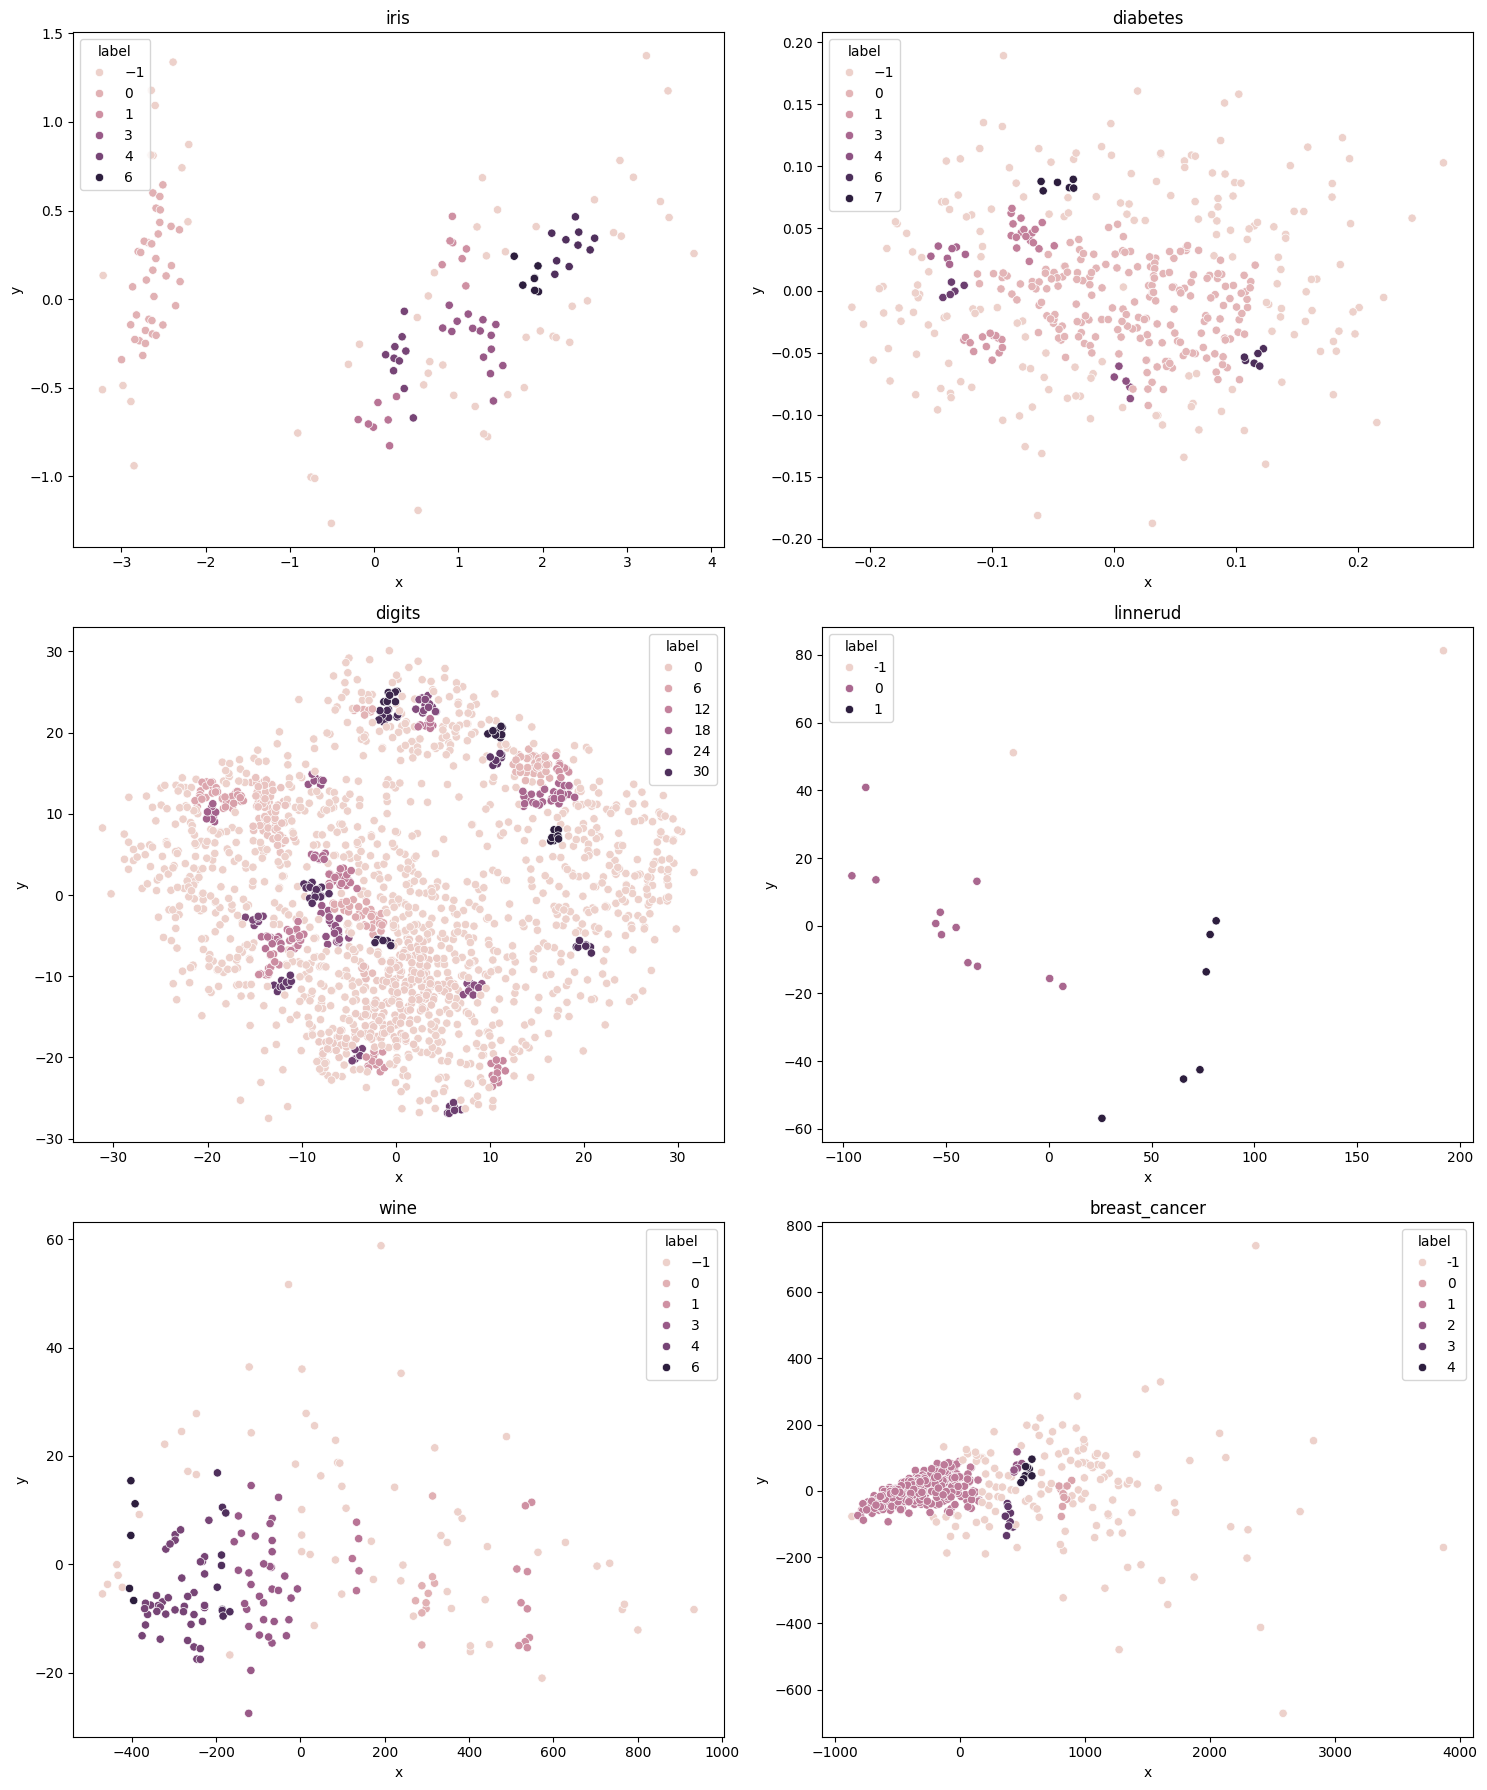

In [ ]:
# Read file into dictionary
file = open("./data_and_solution_labels.json", 'r')
datasets_dict = json.load(file)
file.close()

# Number of datasets to plot in a row, e.g., 3
datasets_per_row = 2
total_datasets = len(datasets_dict)
nrows = (total_datasets - 1) // datasets_per_row + 1
# Adjust figure size based on the number of rows
plt.figure(figsize=(15, 6 * nrows))

for idx, (dataset_name, _) in enumerate(datasets_dict.items()):
    # Calculate subplot position
    subplot_index = idx + 1  # Index starts from 1

    # Plot results
    df = pd.DataFrame(datasets_dict[dataset_name]['data'], columns=['x', 'y'])
    df['label'] = datasets_dict[dataset_name]['labels']
    # Include the dataset_name in the call to plot_labels
    plot_labels(df, datasets_dict[dataset_name]['labels'], nrows=nrows, ncols=datasets_per_row, index=subplot_index, dataset_name=dataset_name)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display all plots at once

### Gráficas de conjuntos de datos sintéticos de distintos tamaños

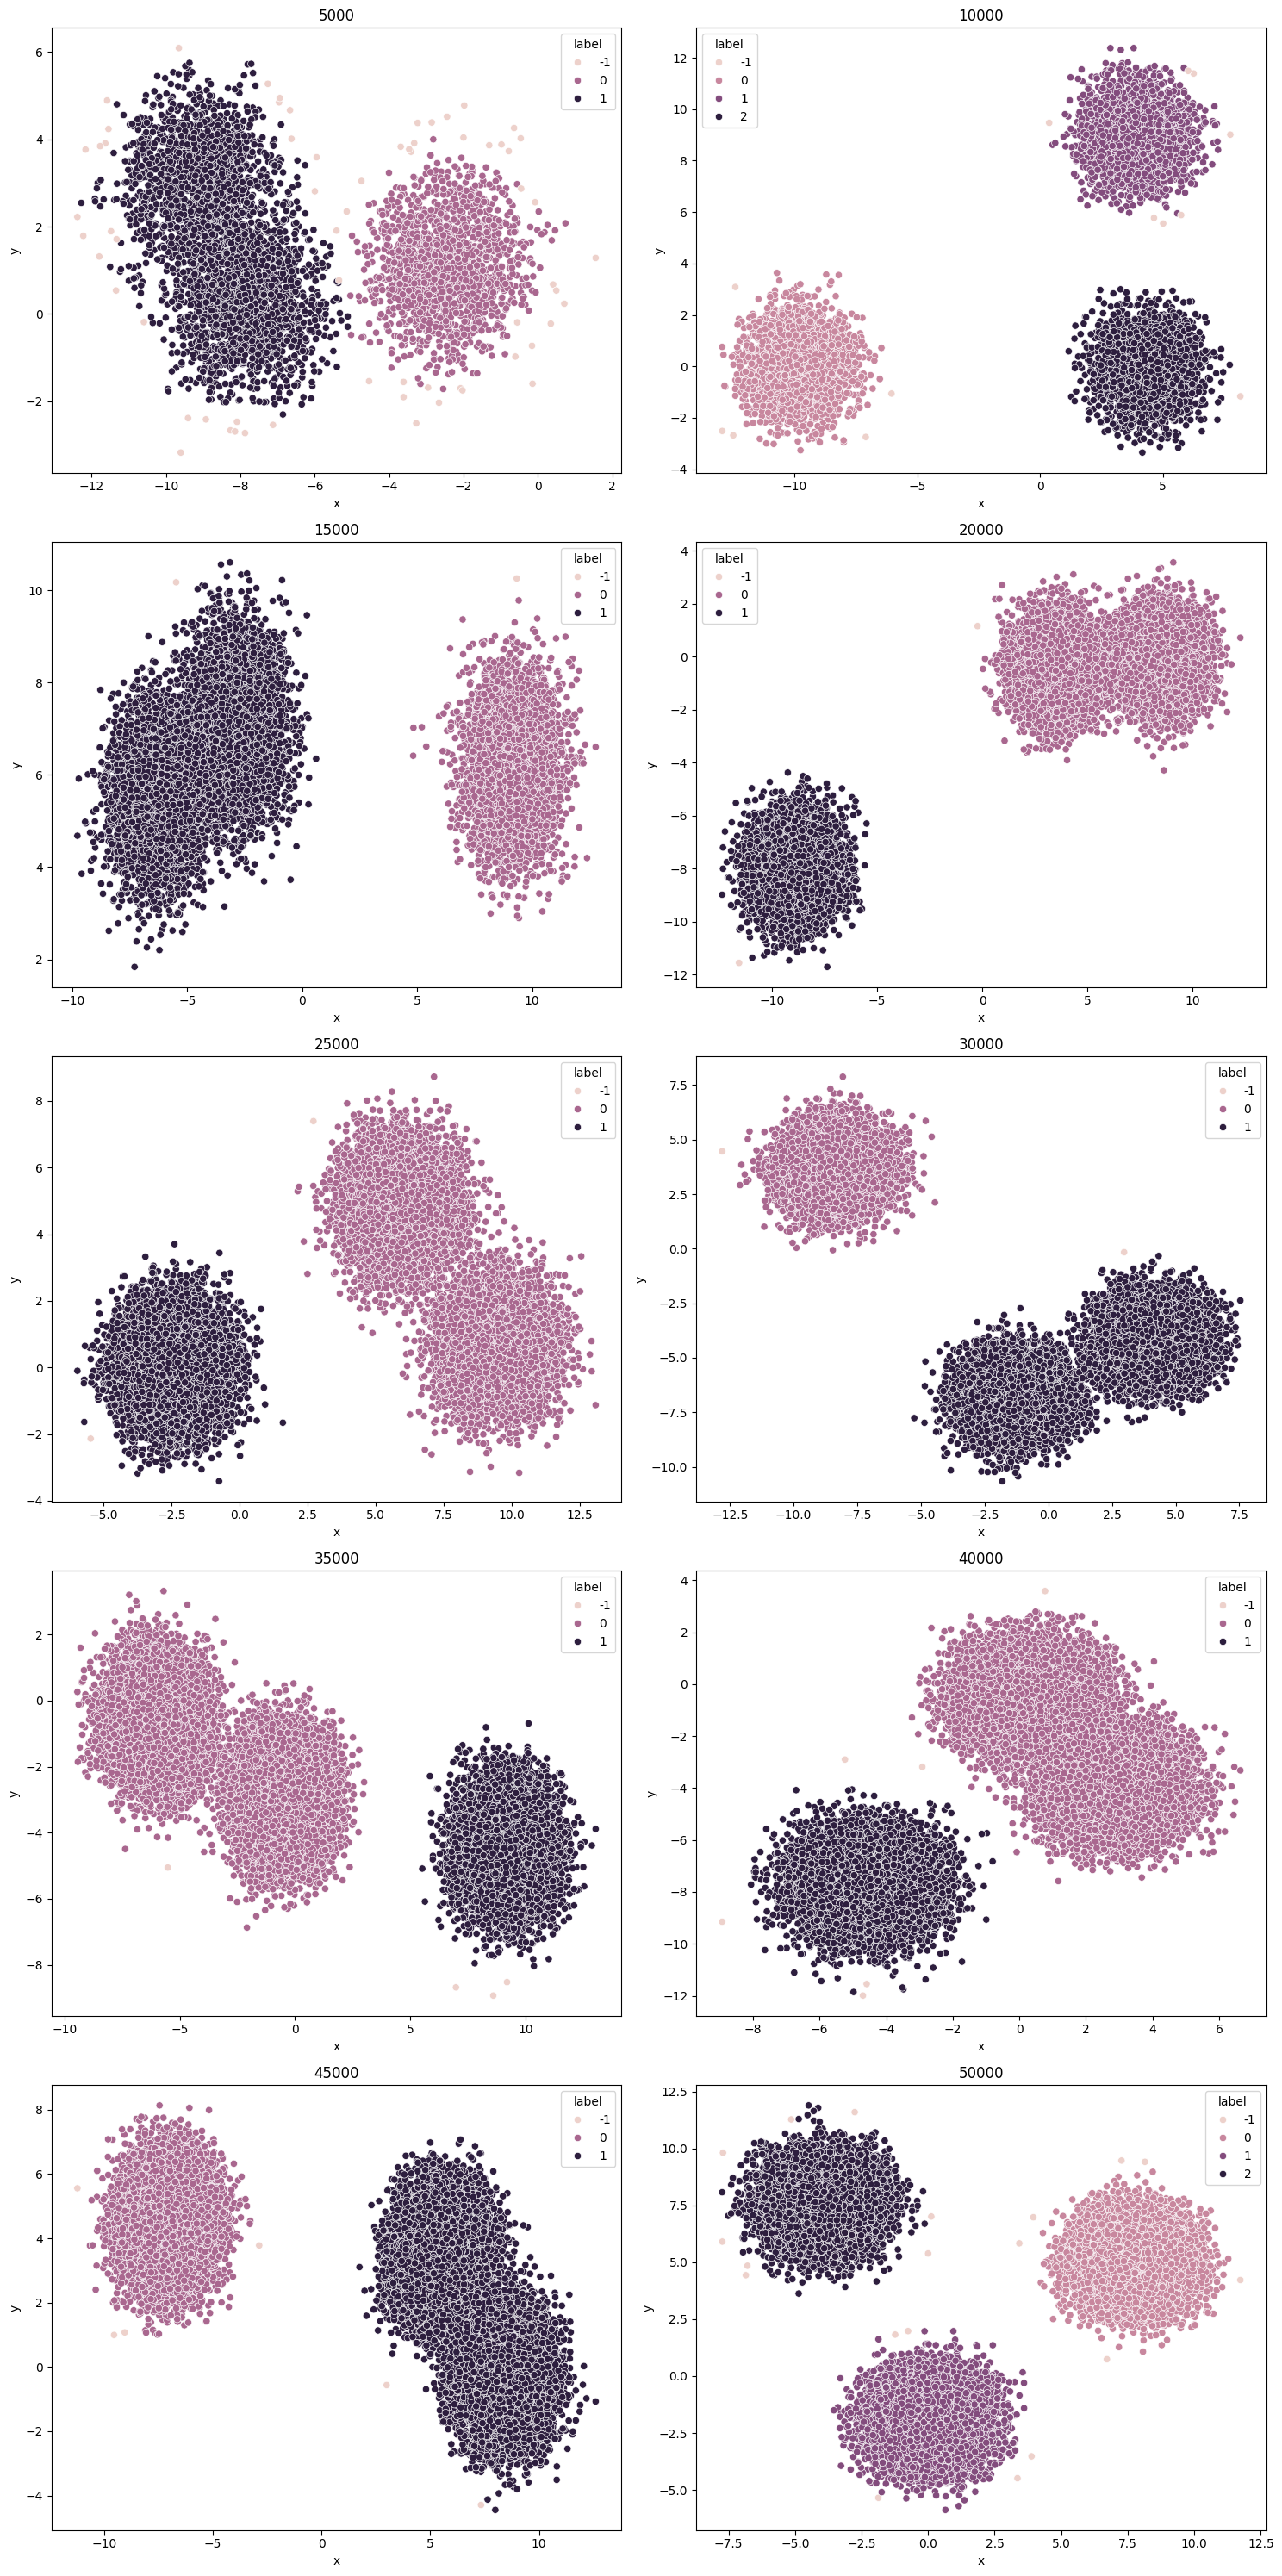

In [ ]:
# Read file into dictionary
with open("./different_sizes_data_and_solution_labels.json", 'r') as file:
    datasets_dict = json.load(file)

# Number of datasets to plot in a row, e.g., 2
datasets_per_row = 2
total_datasets = len(datasets_dict)
nrows = (total_datasets - 1) // datasets_per_row + 1

# Adjust figure size based on the number of rows
plt.figure(figsize=(15, 6 * nrows))

for idx, (dataset_name, dataset_info) in enumerate(datasets_dict.items()):
    # Calculate subplot position
    subplot_index = idx + 1  # Index starts from 1

    # Create a dataframe for the dataset
    df = pd.DataFrame(dataset_info['data'], columns=['x', 'y'])
    df['label'] = dataset_info['labels']

    # Plot results
    # Include the dataset_name in the call to plot_labels
    # plot_labels should be defined to handle the dataframe, labels, and subplot positioning
    plot_labels(df, dataset_info['labels'], nrows=nrows, ncols=datasets_per_row, index=subplot_index, dataset_name=dataset_name)

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()  # Display all plots at once


## Comparación de los tiempos de ejecución y del aceleramiento entre los algoritmos serial y paralelo de DBSCAN

Primero, se obtienen los tiempos promedios con sus respectivas desviaciones estándar de cada ejecución del algoritmo paralelo (i.e. las combinaciones de GPU y dataset), así como de cada ejecución de cada dataset con el algoritmo serial.

Posteriormente, se grafican las comparaciones de los tiempos promedios y las aceleraciones de cada implementación.

Por último, se grafican las comparaciones del uso de memoria RAM.

### Toy Datasets

#### Lectura de archivos JSON con resultados de las experimentaciones

In [ ]:
with open("./sklearn_toy_datasets_results.json", 'r') as file:
  sklearn_results = json.load(file)

with open("./sklearn_modified_toy_datasets_results_T4.json", 'r') as file:
  sklearn_modified_results_T4 = json.load(file)

with open("./sklearn_modified_toy_datasets_results_V100.json", 'r') as file:
  sklearn_modified_results_V100 = json.load(file)

with open("./serial_toy_datasets_results.json", 'r') as file:
  serial_results = json.load(file)

with open("./parallel_toy_datasets_results_V100.json", 'r') as file:
  V100_results = json.load(file)

with open("./parallel_toy_datasets_results_T4.json", 'r') as file:
  T4_results = json.load(file)

FileNotFoundError: [Errno 2] No such file or directory: './sklearn_toy_datasets_results.json'

#### Promedios de tiempos de ejecución

##### Tiempos Sklearn

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN
mean_results_sklearn = {}
for dataset_name, _ in sklearn_results.items():
    number_of_experiments = len(sklearn_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = sklearn_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_sklearn[dataset_name] = {}
    mean_results_sklearn[dataset_name]['mean_time'] = mean_time
    mean_results_sklearn[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_sklearn)

{'iris': {'mean_time': 0.0019131183624267578,
  'std_dev_time': 0.00033036767255752354},
 'diabetes': {'mean_time': 0.003122687339782715,
  'std_dev_time': 0.0006038718333226928},
 'digits': {'mean_time': 0.008950058619181316,
  'std_dev_time': 0.00538282293853092},
 'linnerud': {'mean_time': 0.0015667279561360676,
  'std_dev_time': 0.0003355931134020054},
 'wine': {'mean_time': 0.0020229260126749674,
  'std_dev_time': 0.0005391051463996975},
 'breast_cancer': {'mean_time': 0.004446729024251302,
  'std_dev_time': 0.000912448342182435}}

##### Tiempos Sklearn modificado T4

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified_T4 = {}
for dataset_name, _ in sklearn_modified_results_T4.items():
    number_of_experiments = len(sklearn_modified_results_T4[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = sklearn_modified_results_T4[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_sklearn_modified_T4[dataset_name] = {}
    mean_results_sklearn_modified_T4[dataset_name]['mean_time'] = mean_time
    mean_results_sklearn_modified_T4[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_sklearn_modified_T4)

{'iris': {'mean_time': 0.21021649837493897,
  'std_dev_time': 0.3147005302602308},
 'diabetes': {'mean_time': 0.10718917846679688,
  'std_dev_time': 0.005910709926959165},
 'digits': {'mean_time': 0.15278944969177247,
  'std_dev_time': 0.0037096242575116846},
 'linnerud': {'mean_time': 0.10783295631408692,
  'std_dev_time': 0.007080799741025092},
 'wine': {'mean_time': 0.13146300315856935,
  'std_dev_time': 0.017213482224274306},
 'breast_cancer': {'mean_time': 0.13022999763488768,
  'std_dev_time': 0.019271618234022028}}

##### Tiempos Sklearn modificado V100

In [ ]:
mean_results_sklearn_modified_V100 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in sklearn_modified_results_V100.items():
    number_of_experiments = len(sklearn_modified_results_V100[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = sklearn_modified_results_V100[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_sklearn_modified_V100[dataset_name] = {}
    mean_results_sklearn_modified_V100[dataset_name]['mean_time'] = mean_time
    mean_results_sklearn_modified_V100[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_sklearn_modified_V100)

{'iris': {'mean_time': 0.2159160852432251,
  'std_dev_time': 0.31827442435752645},
 'diabetes': {'mean_time': 0.11838741302490234,
  'std_dev_time': 0.009836660499703461},
 'digits': {'mean_time': 0.15714244842529296,
  'std_dev_time': 0.004382446702300432},
 'linnerud': {'mean_time': 0.11407878398895263,
  'std_dev_time': 0.006114915560164988},
 'wine': {'mean_time': 0.10941359996795655,
  'std_dev_time': 0.005721349063255385},
 'breast_cancer': {'mean_time': 0.15901901721954345,
  'std_dev_time': 0.011544168733627328}}

##### Tiempos Serial

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SERIAL
mean_results_serial = {}
for dataset_name, _ in serial_results.items():
    number_of_experiments = len(serial_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = serial_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_serial[dataset_name] = {}
    mean_results_serial[dataset_name]['mean_time'] = mean_time
    mean_results_serial[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_serial)

{'iris': {'mean_time': 0.030657847722371418,
  'std_dev_time': 0.0019595146195959933},
 'diabetes': {'mean_time': 0.49625078837076825,
  'std_dev_time': 0.00774008493496469},
 'digits': {'mean_time': 4.651887973149617,
  'std_dev_time': 0.5420500267612193},
 'linnerud': {'mean_time': 0.0008559226989746094,
  'std_dev_time': 0.00022385130422234204},
 'wine': {'mean_time': 0.04381044705708822,
  'std_dev_time': 0.0007767303188617245},
 'breast_cancer': {'mean_time': 0.41668542226155597,
  'std_dev_time': 0.003955633680133123}}

##### Tiempos Paralelo GPU V100

In [ ]:
mean_results_V100 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_V100[dataset_name] = {}
    mean_results_V100[dataset_name]['mean_time'] = mean_time
    mean_results_V100[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_V100)

{'iris': {'mean_time': 0.5445892810821533, 'std_dev_time': 0.515917283150217},
 'diabetes': {'mean_time': 0.4126921494801839,
  'std_dev_time': 0.0771800849145916},
 'digits': {'mean_time': 0.9299045403798422,
  'std_dev_time': 0.07589835646709671},
 'linnerud': {'mean_time': 0.11234577496846516,
  'std_dev_time': 0.004774706527912911},
 'wine': {'mean_time': 0.10908087094624837,
  'std_dev_time': 0.011823503613118054},
 'breast_cancer': {'mean_time': 0.12915722529093424,
  'std_dev_time': 0.008189847515779855}}

##### Tiempos Paralelo GPU T4

In [ ]:
mean_results_T4 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_T4[dataset_name] = {}
    mean_results_T4[dataset_name]['mean_time'] = mean_time
    mean_results_T4[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_T4)

{'iris': {'mean_time': 0.5860466957092285, 'std_dev_time': 0.5663180650314975},
 'diabetes': {'mean_time': 0.22105884552001953,
  'std_dev_time': 0.01486461229063374},
 'digits': {'mean_time': 0.78398331006368, 'std_dev_time': 0.1266715526959004},
 'linnerud': {'mean_time': 0.4894992510477702,
  'std_dev_time': 0.02575529083239942},
 'wine': {'mean_time': 0.21353745460510254,
  'std_dev_time': 0.09169894596290616},
 'breast_cancer': {'mean_time': 0.1652959187825521,
  'std_dev_time': 0.057991501556828556}}

#### Gráficas de tiempos de ejecución

En segundo lugar, se grafican los tiempos de ejecución promedio de las ejecuciones de cada dataset con cada algoritmo y cada GPU.

In [ ]:
datasets = list(mean_results_serial.keys())
mean_times_sklearn = [mean_results_sklearn[dataset]['mean_time'] for dataset in datasets]
mean_times_sklearn_modified_T4 = [mean_results_sklearn_modified_T4[dataset]['mean_time'] for dataset in datasets]
mean_times_sklearn_modified_V100 = [mean_results_sklearn_modified_V100[dataset]['mean_time'] for dataset in datasets]
mean_times_serial = [mean_results_serial[dataset]['mean_time'] for dataset in datasets]
mean_times_V100 = [mean_results_V100[dataset]['mean_time'] for dataset in datasets]
mean_times_T4 = [mean_results_T4[dataset]['mean_time'] for dataset in datasets]

x = np.arange(len(datasets))  # the label locations

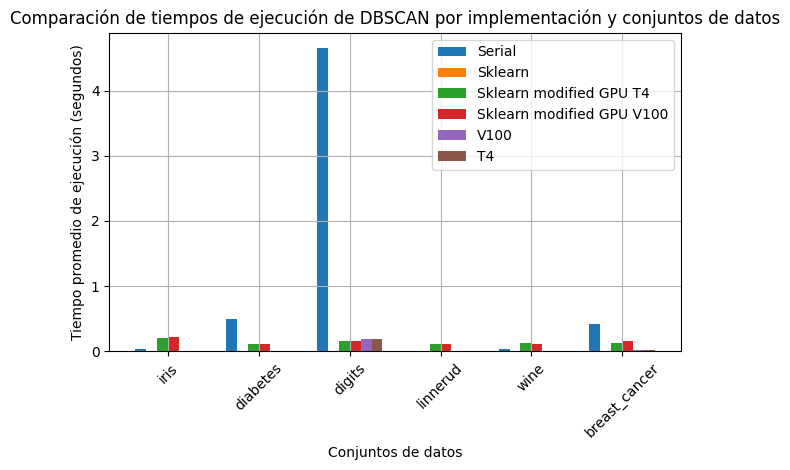

In [ ]:
width = 0.12  # Adjusted width to accommodate 6 series comfortably
fig, ax = plt.subplots()
# Adjust positions to ensure no overlap
rects0 = ax.bar(x - width*2.5, mean_times_serial, width, label='Serial')
rects1 = ax.bar(x - width*1.5, mean_times_sklearn, width, label='Sklearn')
rects2 = ax.bar(x - width*0.5, mean_times_sklearn_modified_T4, width, label='Sklearn modified GPU T4')
rects3 = ax.bar(x + width*0.5, mean_times_sklearn_modified_V100, width, label='Sklearn modified GPU V100')
rects4 = ax.bar(x + width*1.5, mean_times_V100, width, label='V100')
rects5 = ax.bar(x + width*2.5, mean_times_T4, width, label='T4')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN por implementación y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)  # Optional, adds a grid for better readability

# Graficar
fig.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

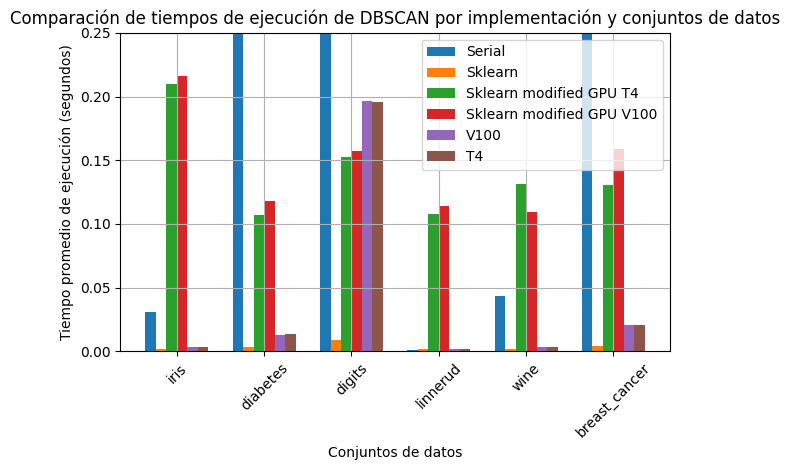

In [ ]:
width = 0.12  # Adjusted width to accommodate 6 series comfortably

fig, ax = plt.subplots()
# Adjust positions to ensure no overlap
rects0 = ax.bar(x - width*2.5, mean_times_serial, width, label='Serial')
rects1 = ax.bar(x - width*1.5, mean_times_sklearn, width, label='Sklearn')
rects2 = ax.bar(x - width*0.5, mean_times_sklearn_modified_T4, width, label='Sklearn modified GPU T4')
rects3 = ax.bar(x + width*0.5, mean_times_sklearn_modified_V100, width, label='Sklearn modified GPU V100')
rects4 = ax.bar(x + width*1.5, mean_times_V100, width, label='V100')
rects5 = ax.bar(x + width*2.5, mean_times_T4, width, label='T4')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN por implementación y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)  # Optional, adds a grid for better readability

# Set y-axis limits to ensure the range 0 to 1 is shown effectively
ax.set_ylim(0, 0.25)  # Setting the y-axis limits from 0 to 1

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()


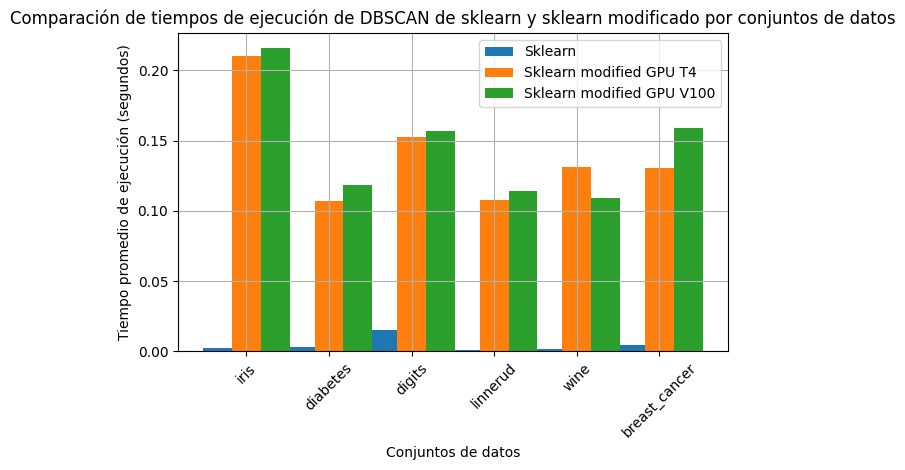

In [ ]:
x = np.arange(len(datasets))  # Ubicaciones de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, mean_times_sklearn, width, label='Sklearn')
rects2 = ax.bar(x, mean_times_sklearn_modified_T4, width, label='Sklearn modified GPU T4')
rects3 = ax.bar(x + width, mean_times_sklearn_modified_V100, width, label='Sklearn modified GPU V100')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN de sklearn y sklearn modificado por conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

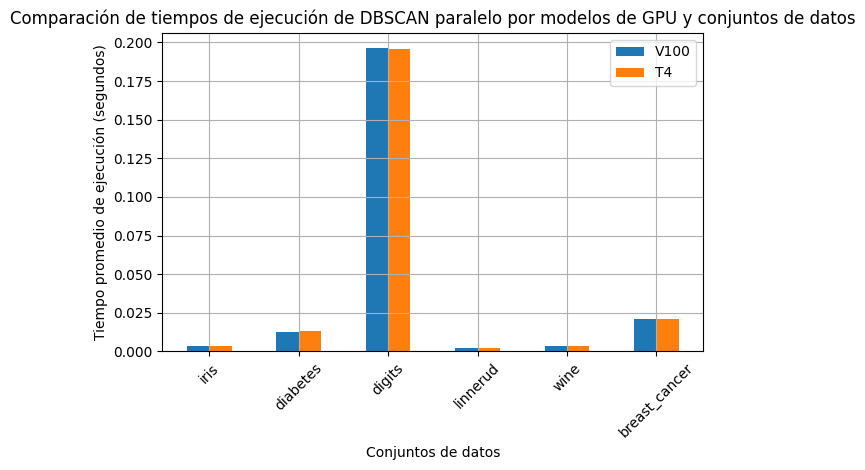

In [ ]:
width = 0.25  # adjusted width to give the bars a better visual separation

fig, ax = plt.subplots()
rects2 = ax.bar(x - width / 2, mean_times_V100, width, label='V100')  # Barra V100 centrada a la izquierda del tick
rects3 = ax.bar(x + width / 2, mean_times_T4, width, label='T4')  # Barra T4 centrada a la derecha del tick


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)

# Adjust for displaying error bars if available
errorbar_positions = [x - width, x, x + width]  # Updated positions for the three series
std_dev_keys = [mean_results_V100, mean_results_T4]  # Only the relevant dictionaries

fig.tight_layout()
plt.show()


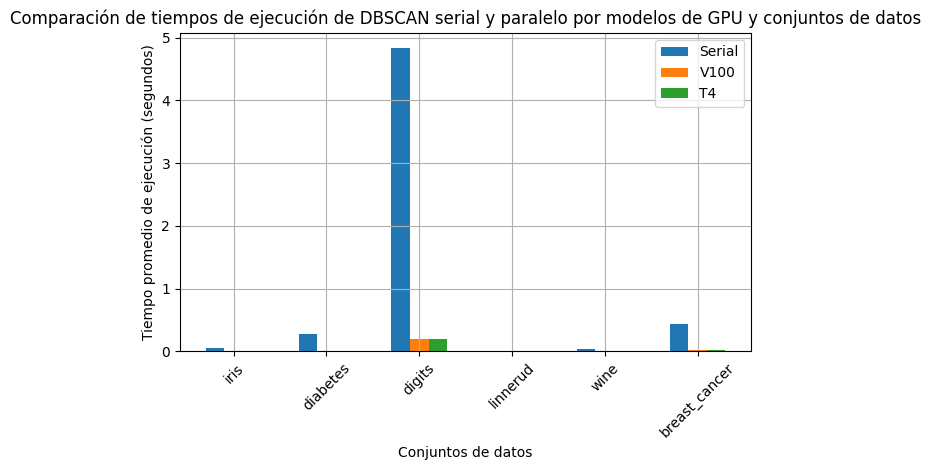

In [ ]:
fig, ax = plt.subplots()
width = 0.2  # Ajustado para acomodar 4 series

# Las posiciones x se ajustan para separar las series de barras
rects1 = ax.bar(x - width, mean_times_serial, width, label='Serial')
rects3 = ax.bar(x, mean_times_V100, width, label='V100')
rects4 = ax.bar(x + width, mean_times_T4, width, label='T4')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN serial y paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

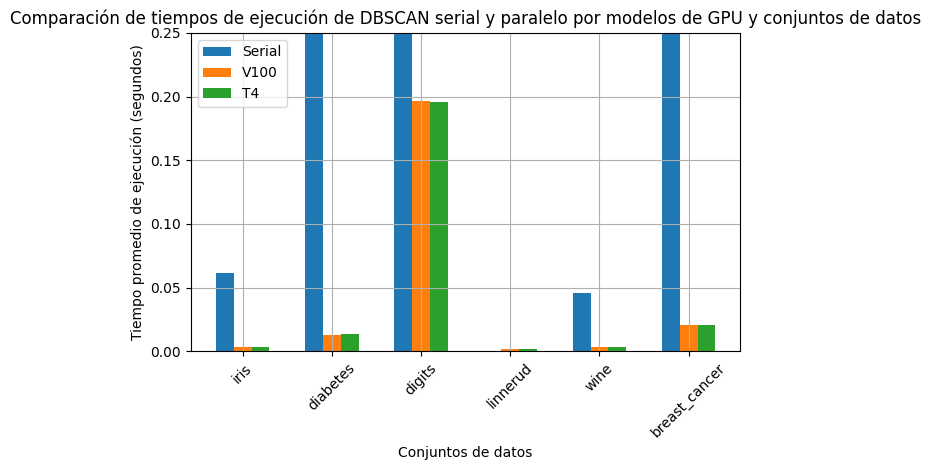

In [ ]:
fig, ax = plt.subplots()
width = 0.2  # Ajustado para acomodar 4 series

# Las posiciones x se ajustan para separar las series de barras
rects1 = ax.bar(x - width, mean_times_serial, width, label='Serial')
rects3 = ax.bar(x, mean_times_V100, width, label='V100')
rects4 = ax.bar(x + width, mean_times_T4, width, label='T4')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN serial y paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
ax.set_ylim(0, 0.25)
fig.tight_layout()
plt.show()

En tercer lugar, se grafica el aceleramiento (speed-up) de las ejecuciones paralelas de cada dataset con cada GPU respecto a la ejecución serial.

#### Gráficas de aceleramiento

##### Aceleramiento respecto a código serial

In [ ]:
# Calculando el speed up respecto a serial
speed_ups_sklearn_modified_T4 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_sklearn_modified_T4[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_sklearn_modified_V100 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_sklearn_modified_V100[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_sklearn = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_sklearn[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_V100 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_V100[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_T4 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_T4[dataset]['mean_time'] for dataset in mean_results_serial}

# Preparación para la gráfica
datasets = list(speed_ups_sklearn_modified_T4.keys())
speed_up_values_sklearn = [speed_ups_sklearn[dataset] for dataset in datasets]
speed_up_values_sklearn_modified_T4 = [speed_ups_sklearn_modified_T4[dataset] for dataset in datasets]
speed_up_values_sklearn_modified_V100 = [speed_ups_sklearn_modified_V100[dataset] for dataset in datasets]
speed_up_values_V100 = [speed_ups_V100[dataset] for dataset in datasets]
speed_up_values_T4 = [speed_ups_T4[dataset] for dataset in datasets]

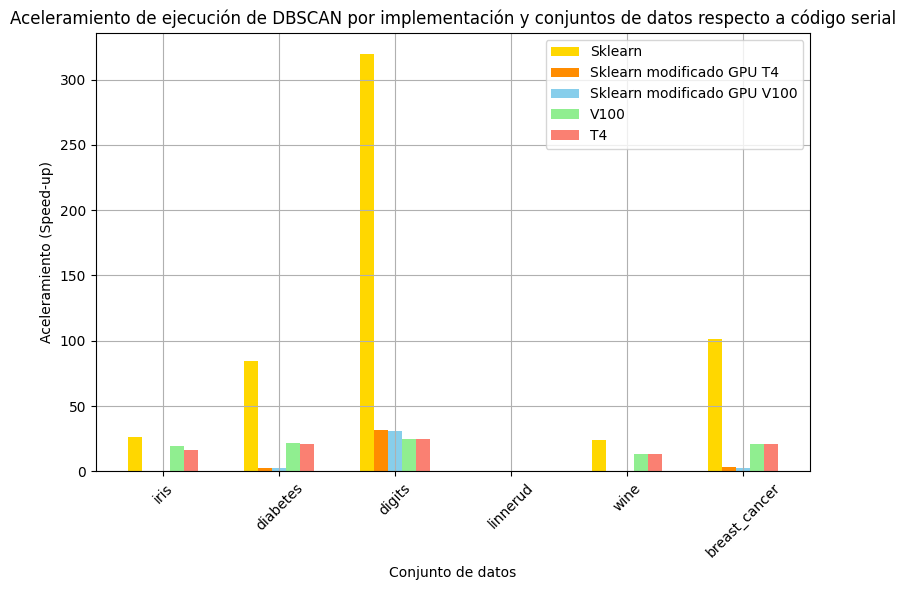

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*2, speed_up_values_sklearn, width, label='Sklearn', color='gold')
rects1 = ax.bar(x - width, speed_up_values_sklearn_modified_T4, width, label='Sklearn modificado GPU T4', color='darkorange')
rects2 = ax.bar(x, speed_up_values_sklearn_modified_V100, width, label='Sklearn modificado GPU V100', color='skyblue')
rects3 = ax.bar(x + width, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*2, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código serial')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()


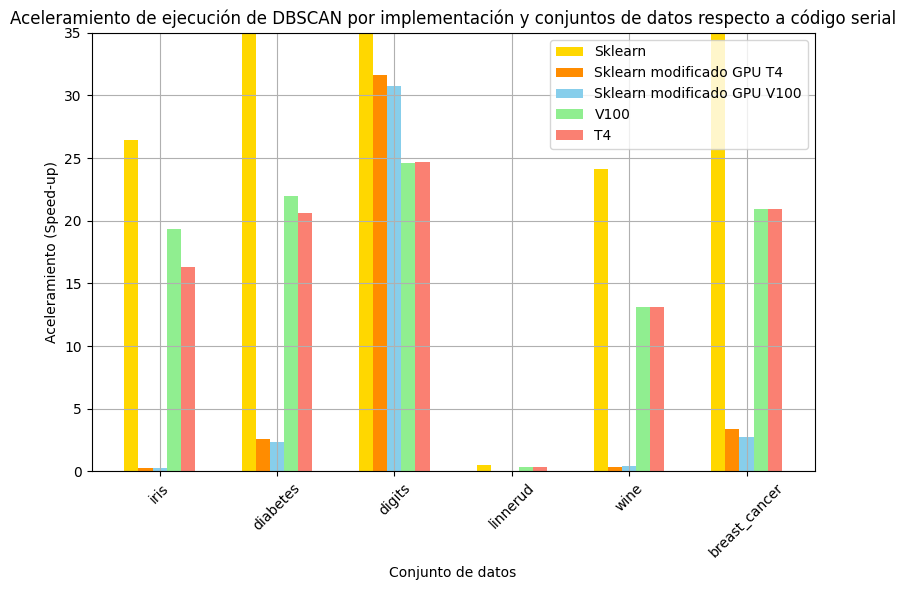

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*2, speed_up_values_sklearn, width, label='Sklearn', color='gold')
rects1 = ax.bar(x - width, speed_up_values_sklearn_modified_T4, width, label='Sklearn modificado GPU T4', color='darkorange')
rects2 = ax.bar(x, speed_up_values_sklearn_modified_V100, width, label='Sklearn modificado GPU V100', color='skyblue')
rects3 = ax.bar(x + width, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*2, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código serial')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)
ax.set_ylim(0, 35)

fig.tight_layout()
plt.show()


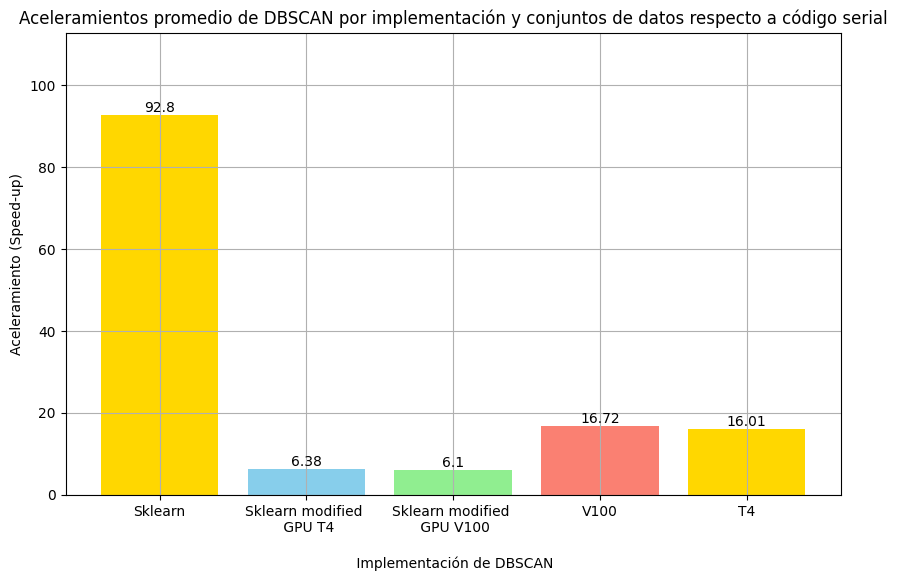

In [ ]:
# Calcular la media de los speed ups para A100, V100, y T4
mean_speedups_sklearn = sum(speed_ups_sklearn.values()) / len(speed_ups_sklearn)
mean_speedups_sklearn_modified_T4 = sum(speed_ups_sklearn_modified_T4.values()) / len(speed_ups_sklearn_modified_T4)
mean_speedups_sklearn_modified_V100 = sum(speed_ups_sklearn_modified_V100.values()) / len(speed_ups_sklearn_modified_V100)
mean_speedups_V100 = sum(speed_ups_V100.values()) / len(speed_ups_V100)
mean_speedups_T4 = sum(speed_ups_T4.values()) / len(speed_ups_T4)

# Nombres de las GPUs y Sklearn
gpus = ['Sklearn', 'Sklearn modified \n GPU T4', 'Sklearn modified \n GPU V100', 'V100', 'T4']

# Medias de los speed ups para cada GPU incluyendo Sklearn
mean_speedups = [mean_speedups_sklearn, mean_speedups_sklearn_modified_T4, mean_speedups_sklearn_modified_V100, mean_speedups_V100, mean_speedups_T4]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(gpus, mean_speedups, color=['gold', 'skyblue', 'lightgreen', 'salmon'])
plt.grid(True)

plt.xlabel('\n Implementación de DBSCAN')
plt.ylabel('Aceleramiento (Speed-up)')
plt.title('Aceleramientos promedio de DBSCAN por implementación y conjuntos de datos respecto a código serial')

# Agregar los valores de mean speed up sobre cada barra
for i, value in enumerate(mean_speedups):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom')

plt.ylim(0, max(mean_speedups) + 20)  # Ajustar el límite superior para mejor visualización

plt.show()


##### Aceleramiento respecto a Sklearn


In [ ]:
# Calculando el speed up
speed_ups_sklearn_modified_T4 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_sklearn_modified_T4[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_sklearn_modified_V100 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_sklearn_modified_V100[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_serial = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_serial[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_V100 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_V100[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_T4 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_T4[dataset]['mean_time'] for dataset in mean_results_sklearn}

# Preparación para la gráfica
datasets = list(speed_ups_sklearn_modified_T4.keys())
speed_up_values_serial = [speed_ups_serial[dataset] for dataset in datasets]
speed_up_values_sklearn_modified_T4 = [speed_ups_sklearn_modified_T4[dataset] for dataset in datasets]
speed_up_values_sklearn_modified_V100 = [speed_ups_sklearn_modified_V100[dataset] for dataset in datasets]
speed_up_values_V100 = [speed_ups_V100[dataset] for dataset in datasets]
speed_up_values_T4 = [speed_ups_T4[dataset] for dataset in datasets]

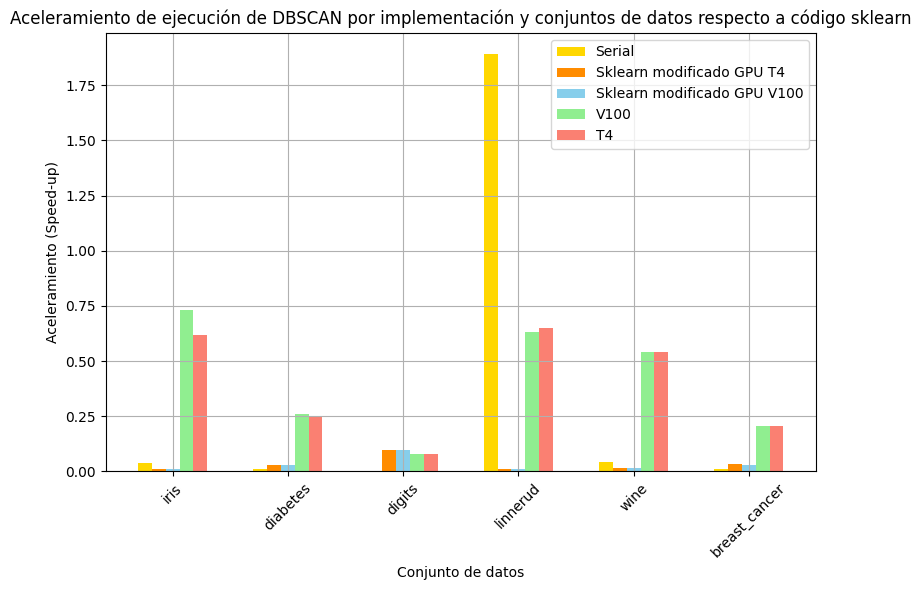

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*2, speed_up_values_serial, width, label='Serial', color='gold')
rects1 = ax.bar(x - width, speed_up_values_sklearn_modified_T4, width, label='Sklearn modificado GPU T4', color='darkorange')
rects2 = ax.bar(x, speed_up_values_sklearn_modified_V100, width, label='Sklearn modificado GPU V100', color='skyblue')
rects3 = ax.bar(x + width, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*2, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código sklearn')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

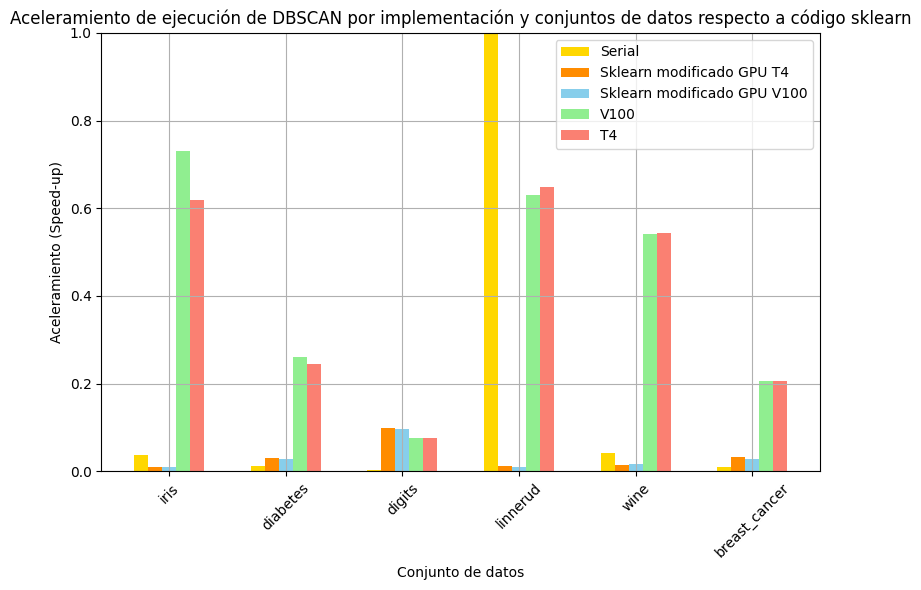

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*2, speed_up_values_serial, width, label='Serial', color='gold')
rects1 = ax.bar(x - width, speed_up_values_sklearn_modified_T4, width, label='Sklearn modificado GPU T4', color='darkorange')
rects2 = ax.bar(x, speed_up_values_sklearn_modified_V100, width, label='Sklearn modificado GPU V100', color='skyblue')
rects3 = ax.bar(x + width, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*2, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código sklearn')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)
ax.set_ylim(0, 1.0)

fig.tight_layout()
plt.show()

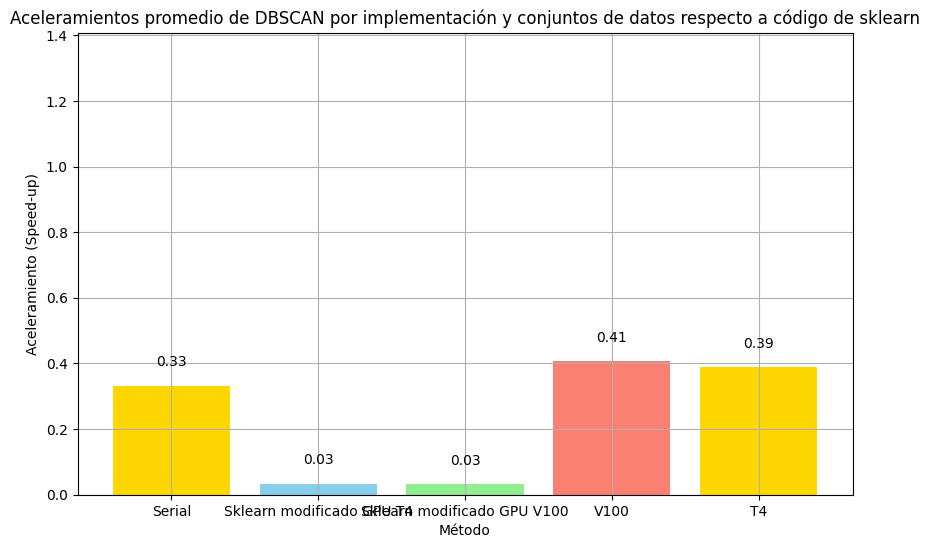

In [ ]:
# Calcular la media de los speed ups para A100, V100, y T4
mean_speedups_serial = sum(speed_ups_serial.values()) / len(speed_ups_serial)
mean_speedups_sklearn_modified_T4 = sum(speed_ups_sklearn_modified_T4.values()) / len(speed_ups_sklearn_modified_T4)
mean_speedups_sklearn_modified_V100 = sum(speed_ups_sklearn_modified_V100.values()) / len(speed_ups_sklearn_modified_V100)
mean_speedups_V100 = sum(speed_ups_V100.values()) / len(speed_ups_V100)
mean_speedups_T4 = sum(speed_ups_T4.values()) / len(speed_ups_T4)

# Nombres de las GPUs y Sklearn
gpus = ['Serial', 'Sklearn modificado GPU T4', 'Sklearn modificado GPU V100', 'V100', 'T4']

# Medias de los speed ups para cada GPU incluyendo Sklearn
mean_speedups = [mean_speedups_serial, mean_speedups_sklearn_modified_T4, mean_speedups_sklearn_modified_V100, mean_speedups_V100, mean_speedups_T4]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(gpus, mean_speedups, color=['gold', 'skyblue', 'lightgreen', 'salmon'])
plt.grid(True)

plt.xlabel('Método')
plt.ylabel('Aceleramiento (Speed-up)')
plt.title('Aceleramientos promedio de DBSCAN por implementación y conjuntos de datos respecto a código de sklearn')

# Agregar los valores de mean speed up sobre cada barra
for i, value in enumerate(mean_speedups):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom')

plt.ylim(0, max(mean_speedups) + 1)  # Ajustar el límite superior para mejor visualización

plt.show()


#### Uso de memoria Toy Dataset

##### Promedios de uso de memoria

###### Memoria Serial

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN
mean_results_serial = {}
for dataset_name, _ in serial_results.items():
    number_of_experiments = len(serial_results[dataset_name]['experiment'])
    sum_memory = 0.0
    std_dev_mem = 0.0
    experiment = serial_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_memory += experiment[idx]['memory_usage']
    mean_memory = sum_memory / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_memory) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_serial[dataset_name] = {}
    mean_results_serial[dataset_name]['mean_cpu_memory'] = mean_memory
    mean_results_serial[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

display(mean_results_serial)

{'iris': {'mean_cpu_memory': 12.199999999999998,
  'std_dev_cpu_memory': 1.7763568394002505e-15},
 'diabetes': {'mean_cpu_memory': 12.300000000000002,
  'std_dev_cpu_memory': 1.7763568394002505e-15},
 'digits': {'mean_cpu_memory': 12.233333333333334,
  'std_dev_cpu_memory': 0.09428090415820684},
 'linnerud': {'mean_cpu_memory': 12.1, 'std_dev_cpu_memory': 0.0},
 'wine': {'mean_cpu_memory': 12.1, 'std_dev_cpu_memory': 0.0},
 'breast_cancer': {'mean_cpu_memory': 12.1, 'std_dev_cpu_memory': 0.0}}

###### Memoria Sklearn

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN
mean_results_sklearn = {}
for dataset_name, _ in sklearn_results.items():
    number_of_experiments = len(sklearn_results[dataset_name]['experiment'])
    sum_memory = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_memory += experiment[idx]['memory_usage']
    mean_memory = sum_memory / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_memory) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn[dataset_name] = {}
    mean_results_sklearn[dataset_name]['mean_cpu_memory'] = mean_memory
    mean_results_sklearn[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

display(mean_results_sklearn)

{'iris': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0},
 'diabetes': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0},
 'digits': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0},
 'linnerud': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0},
 'wine': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0},
 'breast_cancer': {'mean_cpu_memory': 12.5, 'std_dev_cpu_memory': 0.0}}

###### Memoria Sklearn modified GPU T4


In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified_T4 = {}
for dataset_name, _ in sklearn_modified_results_T4.items():
    number_of_experiments = len(sklearn_modified_results_T4[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_T4[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_T4[dataset_name] = {}
    mean_results_sklearn_modified_T4[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_sklearn_modified_T4[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

for dataset_name, _ in sklearn_modified_results_T4.items():
    number_of_experiments = len(sklearn_modified_results_T4[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_T4[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_T4[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_sklearn_modified_T4[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_sklearn_modified_T4)

{'iris': {'mean_cpu_memory': 8.200000000000001,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 2.3999999999999995,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'diabetes': {'mean_cpu_memory': 8.299999999999999,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 2.3999999999999995,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'digits': {'mean_cpu_memory': 8.59,
  'std_dev_cpu_memory': 0.0299999999999999,
  'mean_gpu_memory': 2.8299999999999996,
  'std_dev_gpu_memory': 0.29342801502242416},
 'linnerud': {'mean_cpu_memory': 8.599999999999998,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 2.4899999999999998,
  'std_dev_gpu_memory': 0.1374772708486753},
 'wine': {'mean_cpu_memory': 8.729999999999999,
  'std_dev_cpu_memory': 0.09000000000000052,
  'mean_gpu_memory': 2.3999999999999995,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'breast_cancer': {'mean_cpu_memory': 8.799999999999999,
  'std_dev_cpu_memory': 1.7763568

###### Memoria Sklearn modified GPU V100

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified_V100 = {}
for dataset_name, _ in sklearn_modified_results_V100.items():
    number_of_experiments = len(sklearn_modified_results_V100[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_V100[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_V100[dataset_name] = {}
    mean_results_sklearn_modified_V100[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_sklearn_modified_V100[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

for dataset_name, _ in sklearn_modified_results_V100.items():
    number_of_experiments = len(sklearn_modified_results_V100[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_V100[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_V100[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_sklearn_modified_V100[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_sklearn_modified_V100)

{'iris': {'mean_cpu_memory': 11.700000000000001,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.3,
  'std_dev_gpu_memory': 0.0},
 'diabetes': {'mean_cpu_memory': 11.700000000000001,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.35,
  'std_dev_gpu_memory': 0.05000000000000004},
 'digits': {'mean_cpu_memory': 12.110000000000001,
  'std_dev_cpu_memory': 0.08306623862918044,
  'mean_gpu_memory': 3.7600000000000002,
  'std_dev_gpu_memory': 0.2690724809414741},
 'linnerud': {'mean_cpu_memory': 12.200000000000001,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.3900000000000006,
  'std_dev_gpu_memory': 0.13747727084867534},
 'wine': {'mean_cpu_memory': 12.200000000000001,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.3,
  'std_dev_gpu_memory': 0.0},
 'breast_cancer': {'mean_cpu_memory': 12.22,
  'std_dev_cpu_memory': 0.04000000000000057,
  'mean_gpu_memory': 3.4199999999999995,
  'std_dev_gpu_memo

###### Memoria Paralelo GPU T4

In [ ]:
mean_results_T4 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_T4[dataset_name] = {}
    mean_results_T4[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_T4[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_T4[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_T4[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_T4)

{'iris': {'mean_cpu_memory': 12.166666666666666,
  'std_dev_cpu_memory': 0.09428090415820684,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0},
 'diabetes': {'mean_cpu_memory': 12.4,
  'std_dev_cpu_memory': 0.08164965809277232,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0},
 'digits': {'mean_cpu_memory': 12.866666666666667,
  'std_dev_cpu_memory': 0.12472191289246506,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0},
 'linnerud': {'mean_cpu_memory': 13.4,
  'std_dev_cpu_memory': 0.08164965809277232,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0},
 'wine': {'mean_cpu_memory': 13.533333333333333,
  'std_dev_cpu_memory': 0.047140452079103,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0},
 'breast_cancer': {'mean_cpu_memory': 13.6,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 2.4,
  'std_dev_gpu_memory': 0.0}}

###### Memoria Paralelo V100

In [ ]:
mean_results_V100 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_V100[dataset_name] = {}
    mean_results_V100[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_V100[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_V100[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_V100[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_V100)

{'iris': {'mean_cpu_memory': 11.833333333333334,
  'std_dev_cpu_memory': 0.047140452079103,
  'mean_gpu_memory': 3.2999999999999994,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'diabetes': {'mean_cpu_memory': 12.299999999999999,
  'std_dev_cpu_memory': 0.14142135623730984,
  'mean_gpu_memory': 3.2999999999999994,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'digits': {'mean_cpu_memory': 12.666666666666666,
  'std_dev_cpu_memory': 0.047140452079103,
  'mean_gpu_memory': 3.4,
  'std_dev_gpu_memory': 0.0},
 'linnerud': {'mean_cpu_memory': 12.699999999999998,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.3666666666666667,
  'std_dev_gpu_memory': 0.04714045207910321},
 'wine': {'mean_cpu_memory': 12.699999999999998,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  'mean_gpu_memory': 3.2999999999999994,
  'std_dev_gpu_memory': 4.440892098500626e-16},
 'breast_cancer': {'mean_cpu_memory': 12.699999999999998,
  'std_dev_cpu_memory': 1.7763568394002505e-15,
  

##### Graficas uso de memoria Toy Datasets

Memoria RAM

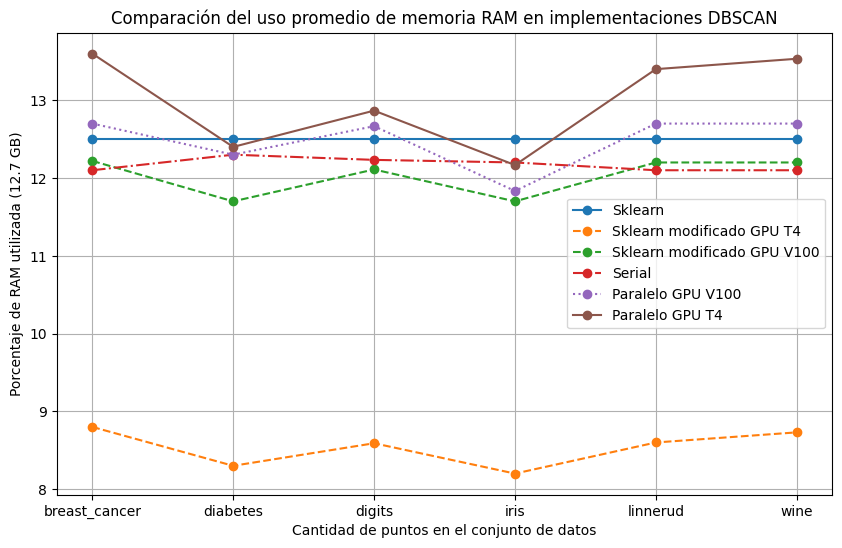

In [ ]:
def extract_data(dic):
    x_values = [key for key in dic.keys()]
    y_values = [val['mean_cpu_memory'] for val in dic.values()]
    # Ordenar x e y según x para asegurar que el gráfico se vea correcto
    sorted_indices = np.argsort(x_values)
    return np.array(x_values)[sorted_indices], np.array(y_values)[sorted_indices]

# Extraer datos para cada diccionario
x, y_sklearn = extract_data(mean_results_sklearn)
_, y_sklearn_mod_T4 = extract_data(mean_results_sklearn_modified_T4)
_, y_sklearn_mod_V100 = extract_data(mean_results_sklearn_modified_V100)
_, y_serial = extract_data(mean_results_serial)
_, y_V100 = extract_data(mean_results_V100)
_, y_T4 = extract_data(mean_results_T4)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_sklearn, label='Sklearn', marker='o', linestyle='-')
plt.plot(x, y_sklearn_mod_T4, label='Sklearn modificado GPU T4', marker='o', linestyle='--')
plt.plot(x, y_sklearn_mod_V100, label='Sklearn modificado GPU V100', marker='o', linestyle='--')
plt.plot(x, y_serial, label='Serial', marker='o', linestyle='-.')
plt.plot(x, y_V100, label='Paralelo GPU V100', marker='o', linestyle=':')
plt.plot(x, y_T4, label='Paralelo GPU T4', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de RAM utilizada (12.7 GB)')
plt.title('Comparación del uso promedio de memoria RAM en implementaciones DBSCAN')
plt.xticks(x)  # Asegurar que todos los valores de x aparezcan como etiquetas
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()

Memoria VRAM

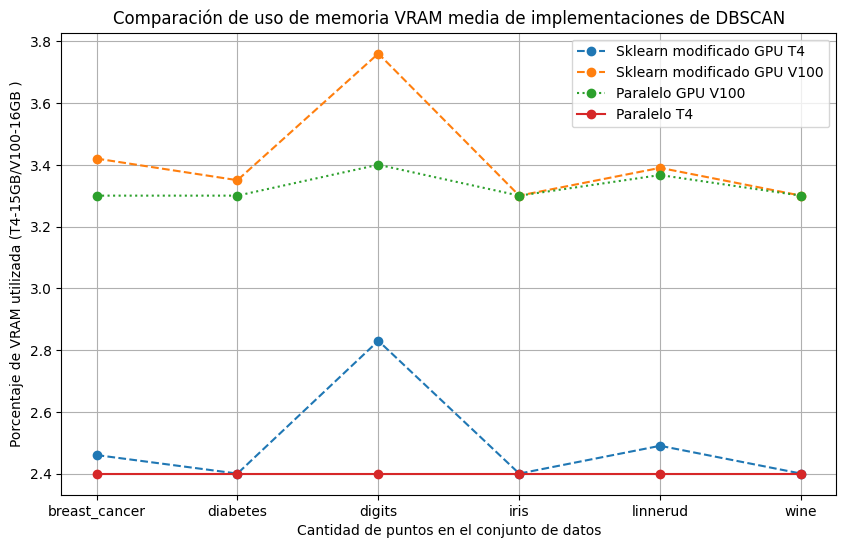

In [ ]:
def extract_data(dic):
    x_values = [key for key in dic.keys()]
    y_values = [val['mean_gpu_memory'] for val in dic.values()]
    # Ordenar x e y según x para asegurar que el gráfico se vea correcto
    sorted_indices = np.argsort(x_values)
    return np.array(x_values)[sorted_indices], np.array(y_values)[sorted_indices]

# Extraer datos para cada diccionario
x, y_sklearn_mod_T4 = extract_data(mean_results_sklearn_modified_T4)
_, y_sklearn_mod_V100 = extract_data(mean_results_sklearn_modified_V100)
_, y_V100 = extract_data(mean_results_V100)
_, y_T4 = extract_data(mean_results_T4)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_sklearn_mod_T4, label='Sklearn modificado GPU T4', marker='o', linestyle='--')
plt.plot(x, y_sklearn_mod_V100, label='Sklearn modificado GPU V100', marker='o', linestyle='--')
plt.plot(x, y_V100, label='Paralelo GPU V100', marker='o', linestyle=':')
plt.plot(x, y_T4, label='Paralelo T4', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de VRAM utilizada (T4-15GB/V100-16GB )')
plt.title('Comparación de uso de memoria VRAM media de implementaciones de DBSCAN')
plt.xticks(x)  # Asegurar que todos los valores de x aparezcan como etiquetas
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()


### Conjuntos de datos sintéticos de distintos tamaños

#### Lectura de archivos JSON con resultados de las experimentaciones

In [ ]:
with open("./sklearn_different_size_results.json", 'r') as file:
  sklearn_results = json.load(file)

with open("./sklearn_modified_different_size_results_T4.json", 'r') as file:
  sklearn_modified_results_T4 = json.load(file)

with open("./sklearn_modified_different_size_results_V100.json", 'r') as file:
  sklearn_modified_results_V100 = json.load(file)

with open("./serial_different_size_results.json", 'r') as file:
  serial_results = json.load(file)

with open("./parallel_different_size_results_V100.json", 'r') as file:
  V100_results = json.load(file)

with open("./parallel_different_size_results_T4.json", 'r') as file:
  T4_results = json.load(file)

#### Promedios de tiempos de ejecución

##### Tiempos Sklearn

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN
mean_results_sklearn = {}
for dataset_name, _ in sklearn_results.items():
    number_of_experiments = len(sklearn_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = sklearn_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_sklearn[dataset_name] = {}
    mean_results_sklearn[dataset_name]['mean_time'] = mean_time
    mean_results_sklearn[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_sklearn)

{'5000': {'mean_time': 0.10882830619812012,
  'std_dev_time': 0.042918455805828204},
 '10000': {'mean_time': 0.17728919982910157,
  'std_dev_time': 0.003982449241597843},
 '15000': {'mean_time': 0.4654459714889526,
  'std_dev_time': 0.07792457727593444},
 '20000': {'mean_time': 0.8749030828475952,
  'std_dev_time': 0.3990578482480494},
 '25000': {'mean_time': 1.2043258666992187,
  'std_dev_time': 0.17630139832945127},
 '30000': {'mean_time': 1.4785248517990113,
  'std_dev_time': 0.20745490700202052},
 '35000': {'mean_time': 2.270347332954407,
  'std_dev_time': 0.31266552815528065},
 '40000': {'mean_time': 2.807578444480896,
  'std_dev_time': 0.34702241285480356},
 '45000': {'mean_time': 3.25141761302948, 'std_dev_time': 0.40992799142548964},
 '50000': {'mean_time': 2.7641141176223756,
  'std_dev_time': 0.5641786570277376}}

##### Tiempos Sklearn modificado

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified = {}
for dataset_name, _ in sklearn_modified_results.items():
    number_of_experiments = len(sklearn_modified_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = sklearn_modified_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_sklearn_modified[dataset_name] = {}
    mean_results_sklearn_modified[dataset_name]['mean_time'] = mean_time
    mean_results_sklearn_modified[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_sklearn_modified)

{'5000': {'mean_time': 0.6418511390686035,
  'std_dev_time': 0.25984462834549216},
 '10000': {'mean_time': 1.9546889781951904,
  'std_dev_time': 0.014283276966505689},
 '15000': {'mean_time': 4.427553820610046,
  'std_dev_time': 0.022209885251828404},
 '20000': {'mean_time': 7.79265673160553, 'std_dev_time': 0.07972433801074973},
 '25000': {'mean_time': 12.178718829154969,
  'std_dev_time': 0.053982571093893116},
 '30000': {'mean_time': 17.237313556671143,
  'std_dev_time': 0.04592966196790567},
 '35000': {'mean_time': 23.398277258872987,
  'std_dev_time': 0.04035363010889275},
 '40000': {'mean_time': 30.39927020072937,
  'std_dev_time': 0.08723342782087709}}

##### Tiempos serial

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SERIAL
mean_results_serial = {}
for dataset_name, _ in serial_results.items():
    number_of_experiments = len(serial_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = serial_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_serial[dataset_name] = {}
    mean_results_serial[dataset_name]['mean_time'] = mean_time
    mean_results_serial[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_serial)

{'5000': {'mean_time': 36.54699170589447, 'std_dev_time': 0.2166355848312378},
 '10000': {'mean_time': 147.93856132030487,
  'std_dev_time': 0.5057719945907593},
 '15000': {'mean_time': 335.187463760376, 'std_dev_time': 1.935377836227417},
 '20000': {'mean_time': 596.135239481926, 'std_dev_time': 1.022074818611145},
 '25000': {'mean_time': 952.4188542366028, 'std_dev_time': 6.591421842575073},
 '30000': {'mean_time': 1347.4269013404846, 'std_dev_time': 4.908547878265381},
 '35000': {'mean_time': 1828.817394375801, 'std_dev_time': 0.6869078874588013},
 '40000': {'mean_time': 2379.905950665474, 'std_dev_time': 2.1729098558425903},
 '45000': {'mean_time': 3009.8564043045044, 'std_dev_time': 1.745819091796875},
 '50000': {'mean_time': 3679.6676400899887, 'std_dev_time': 20.89844024181366}}

##### Tiempos GPU V100

In [ ]:
mean_results_V100 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_V100[dataset_name] = {}
    mean_results_V100[dataset_name]['mean_time'] = mean_time
    mean_results_V100[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_V100)

{'5000': {'mean_time': 1.6792501211166382,
  'std_dev_time': 0.004245638847351074},
 '10000': {'mean_time': 6.697356224060059,
  'std_dev_time': 0.03743314743041992},
 '15000': {'mean_time': 15.924493074417114,
  'std_dev_time': 0.008495330810546875},
 '20000': {'mean_time': 28.526293635368347,
  'std_dev_time': 0.11470425128936768},
 '25000': {'mean_time': 46.60702991485596,
  'std_dev_time': 0.11412644386291504},
 '30000': {'mean_time': 62.64830982685089, 'std_dev_time': 0.9996052980422974},
 '35000': {'mean_time': 85.82170462608337,
  'std_dev_time': 0.19246125221252441},
 '40000': {'mean_time': 114.0313845872879, 'std_dev_time': 1.3642336130142212},
 '45000': {'mean_time': 140.7001280784607, 'std_dev_time': 2.629753351211548},
 '50000': {'mean_time': 165.24236524105072,
  'std_dev_time': 0.46519243717193604}}

##### Tiempos GPU T4

In [ ]:
mean_results_T4 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_time = 0.0
    std_dev_time = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_time += experiment[idx]['execution_time']
    mean_time = sum_time / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_time += (experiment[idx]['execution_time'] - mean_time) ** 2
    std_dev_time = np.sqrt(std_dev_time / number_of_experiments)

    mean_results_T4[dataset_name] = {}
    mean_results_T4[dataset_name]['mean_time'] = mean_time
    mean_results_T4[dataset_name]['std_dev_time'] = std_dev_time

display(mean_results_T4)

{'5000': {'mean_time': 2.561763048171997, 'std_dev_time': 1.0134055614471436},
 '10000': {'mean_time': 7.146805644035339, 'std_dev_time': 0.5976980924606323},
 '15000': {'mean_time': 17.034587144851685,
  'std_dev_time': 0.8230195045471191},
 '20000': {'mean_time': 31.130282521247864,
  'std_dev_time': 0.19780194759368896},
 '25000': {'mean_time': 48.98407590389252,
  'std_dev_time': 0.26708948612213135},
 '30000': {'mean_time': 67.40044486522675,
  'std_dev_time': 0.13928759098052979},
 '35000': {'mean_time': 91.3693414926529,
  'std_dev_time': 0.0037459135055541992},
 '40000': {'mean_time': 118.94949412345886, 'std_dev_time': 1.207209825515747},
 '45000': {'mean_time': 150.00162494182587,
  'std_dev_time': 0.09872806072235107},
 '50000': {'mean_time': 175.77972221374512,
  'std_dev_time': 0.20546865463256836}}

#### Gráficas de tiempos de ejecución

In [ ]:
datasets = list(mean_results_sklearn_modified.keys())
mean_times_sklearn_modified = [mean_results_sklearn_modified[dataset]['mean_time'] for dataset in datasets]
missing_values = len(x) - len(mean_times_sklearn_modified) - 1
mean_times_sklearn_modified = np.pad(mean_times_sklearn_modified, (1, missing_values), 'constant')

datasets = list(mean_results_serial.keys())
mean_times_sklearn = [mean_results_sklearn[dataset]['mean_time'] for dataset in datasets]
mean_times_serial = [mean_results_serial[dataset]['mean_time'] for dataset in datasets]
mean_times_V100 = [mean_results_V100[dataset]['mean_time'] for dataset in datasets]
mean_times_T4 = [mean_results_T4[dataset]['mean_time'] for dataset in datasets]
x = np.arange(len(datasets))  # the label locations


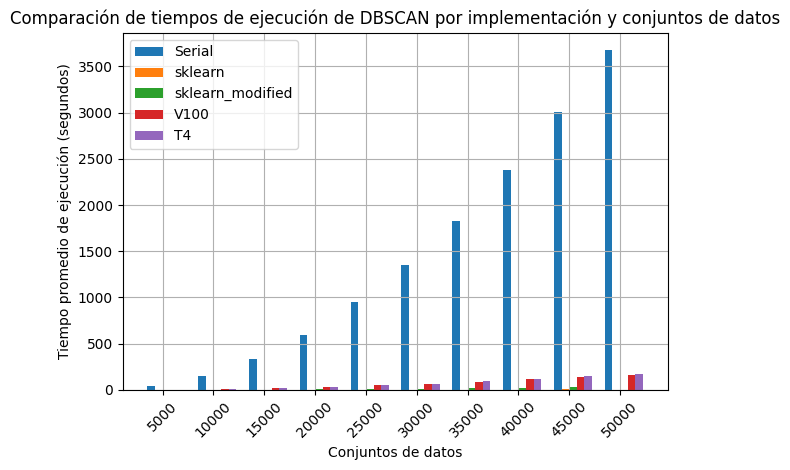

In [ ]:
width = 0.15  # Adjusted width to accommodate remaining series comfortably

fig, ax = plt.subplots()
# Adjust positions to ensure no overlap and symmetry
rects0 = ax.bar(x - 1.5*width, mean_times_serial, width, label='Serial')
rects1 = ax.bar(x - 0.5*width, mean_times_sklearn, width, label='sklearn')
rects2 = ax.bar(x + 0.5*width, mean_times_sklearn_modified, width, label='sklearn_modified')
rects4 = ax.bar(x + 1.5*width, mean_times_V100, width, label='V100')
rects5 = ax.bar(x + 2.5*width, mean_times_T4, width, label='T4')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN por implementación y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)  # Optional, adds a grid for better readability

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

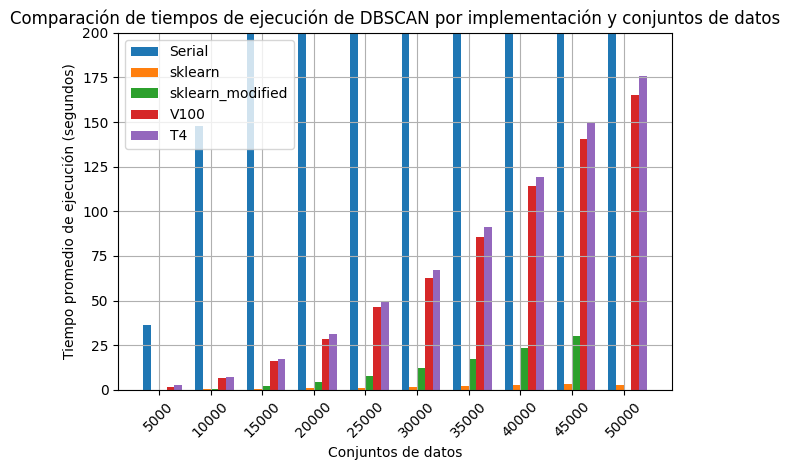

In [ ]:
width = 0.15  # Adjusted width to accommodate remaining series comfortably

fig, ax = plt.subplots()
# Adjust positions to ensure no overlap and symmetry
rects0 = ax.bar(x - 1.5*width, mean_times_serial, width, label='Serial')
rects1 = ax.bar(x - 0.5*width, mean_times_sklearn, width, label='sklearn')
rects2 = ax.bar(x + 0.5*width, mean_times_sklearn_modified, width, label='sklearn_modified')
rects4 = ax.bar(x + 1.5*width, mean_times_V100, width, label='V100')
rects5 = ax.bar(x + 2.5*width, mean_times_T4, width, label='T4')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN por implementación y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)  # Optional, adds a grid for better readability
ax.set_ylim(0, 200)

fig.tight_layout()  # Adjust layout to make sure everything fits without overlap
plt.show()

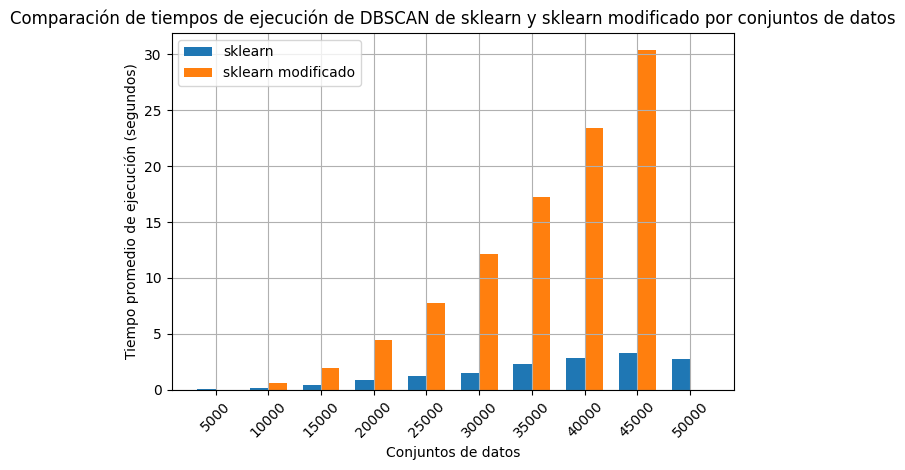

In [ ]:
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mean_times_sklearn, width, label='sklearn')
rects2 = ax.bar(x + width/2, mean_times_sklearn_modified, width, label='sklearn modificado')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN de sklearn y sklearn modificado por conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

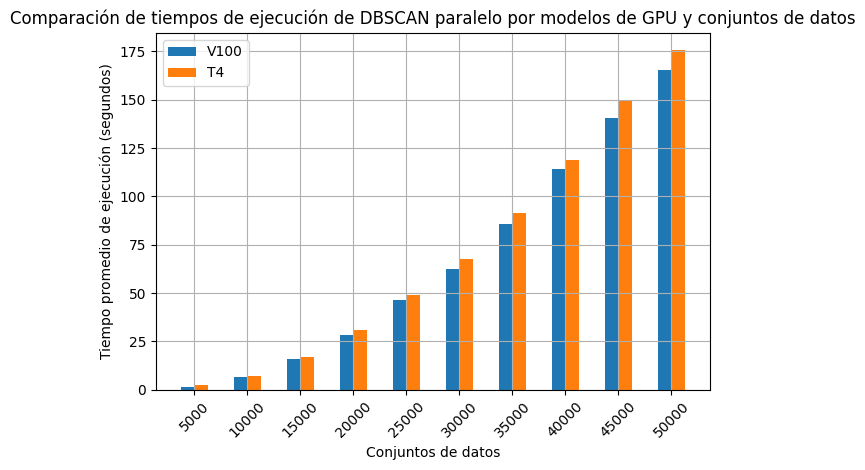

In [ ]:
width = 0.25  # adjusted width to give the bars a better visual separation

fig, ax = plt.subplots()
rects0 = ax.bar(x - width / 2, mean_times_V100, width, label='V100')
rects1 = ax.bar(x + width / 2, mean_times_T4, width, label='T4')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotate dataset names for better visibility
ax.legend()
ax.grid(True)

# Adjust for displaying error bars if available
errorbar_positions = [x - width, x, x + width]  # Updated positions for the three series
std_dev_keys = [mean_results_A100, mean_results_V100, mean_results_T4]  # Only the relevant dictionaries

fig.tight_layout()
plt.show()


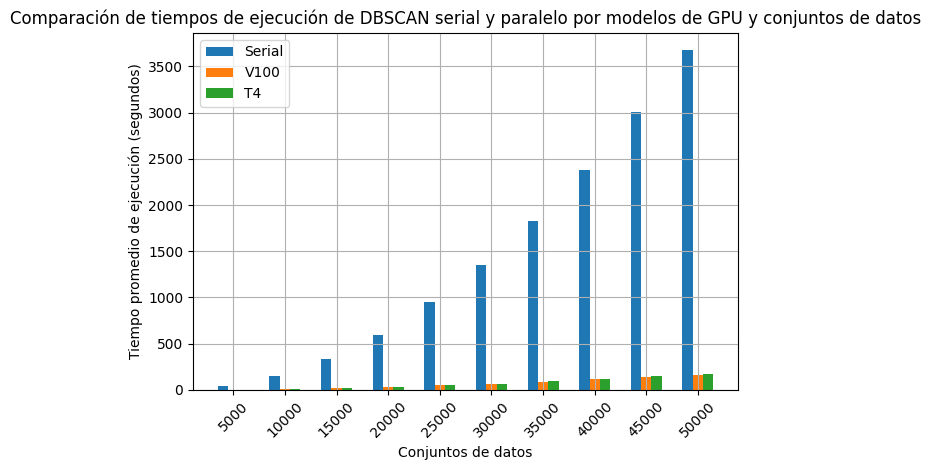

In [ ]:
fig, ax = plt.subplots()
width = 0.2  # Ajustado para acomodar 4 series

# Las posiciones x se ajustan para separar las series de barras
rects1 = ax.bar(x - width, mean_times_serial, width, label='Serial')  # Centered left of the tick mark
rects3 = ax.bar(x, mean_times_V100, width, label='V100')               # Centered directly on the tick mark
rects4 = ax.bar(x + width, mean_times_T4, width, label='T4')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN serial y paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

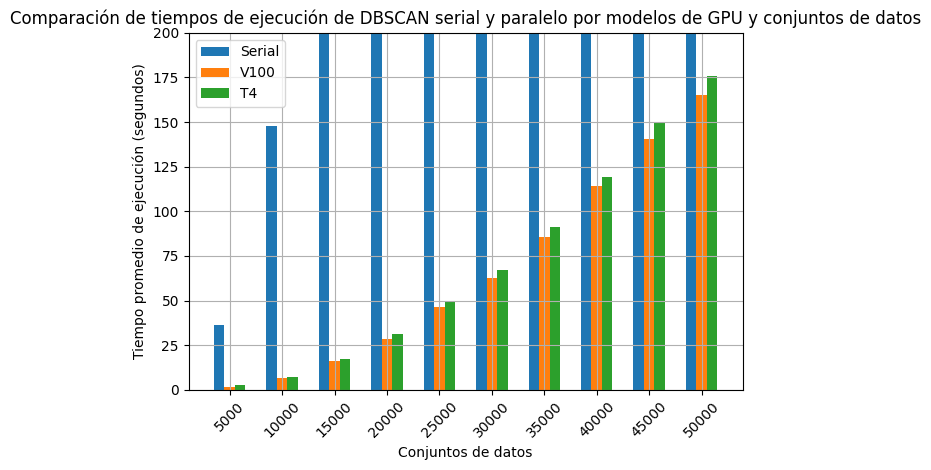

In [ ]:
fig, ax = plt.subplots()
width = 0.2  # Ajustado para acomodar 4 series

# Las posiciones x se ajustan para separar las series de barras
rects1 = ax.bar(x - width, mean_times_serial, width, label='Serial')  # Centered left of the tick mark
rects3 = ax.bar(x, mean_times_V100, width, label='V100')               # Centered directly on the tick mark
rects4 = ax.bar(x + width, mean_times_T4, width, label='T4')

# Añadir texto para las etiquetas, título y etiquetas personalizadas del eje X, etc.
ax.set_xlabel('Conjuntos de datos')
ax.set_ylabel('Tiempo promedio de ejecución (segundos)')
ax.set_title('Comparación de tiempos de ejecución de DBSCAN serial y paralelo por modelos de GPU y conjuntos de datos')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)
ax.legend()
ax.grid(True)
ax.set_ylim(0, 200)
fig.tight_layout()
plt.show()

#### Gráficas de aceleramiento

##### Aceleramiento respecto a código serial

In [ ]:
# Calculando el speed up respecto a serial
speed_ups_sklearn_modified = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_sklearn_modified[dataset]['mean_time'] for dataset in mean_results_sklearn_modified}
speed_ups_sklearn = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_sklearn[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_V100 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_V100[dataset]['mean_time'] for dataset in mean_results_serial}
speed_ups_T4 = {dataset: mean_results_serial[dataset]['mean_time'] / mean_results_T4[dataset]['mean_time'] for dataset in mean_results_serial}

# Preparación para la gráfica
datasets = list(mean_results_sklearn_modified.keys())
speed_up_values_sklearn_modified = [speed_ups_sklearn_modified[dataset] for dataset in datasets]
datasets = list(mean_results_serial.keys())
speed_up_values_sklearn = [speed_ups_sklearn[dataset] for dataset in datasets]
speed_up_values_V100 = [speed_ups_V100[dataset] for dataset in datasets]
speed_up_values_T4 = [speed_ups_T4[dataset] for dataset in datasets]

x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas

missing_values = len(x) - len(speed_up_values_sklearn_modified) - 1
speed_up_values_sklearn_modified = np.pad(speed_up_values_sklearn_modified, (1, missing_values), 'constant')

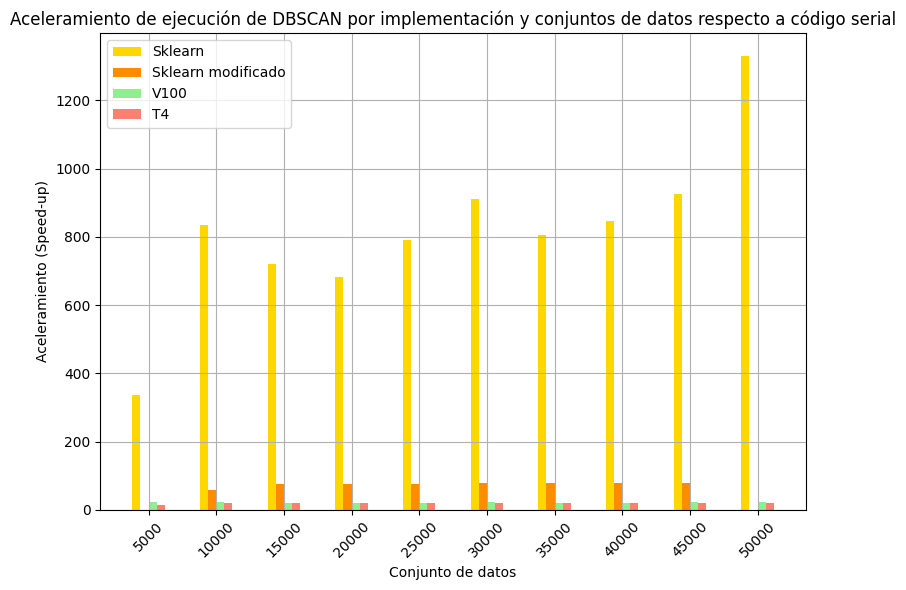

In [ ]:
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*1.5, speed_up_values_sklearn, width, label='Sklearn', color='gold')
rects1 = ax.bar(x - width/2, speed_up_values_sklearn_modified, width, label='Sklearn modificado', color='darkorange')
rects3 = ax.bar(x + width/2, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*1.5, speed_up_values_T4, width, label='T4', color='salmon')


# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código serial')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

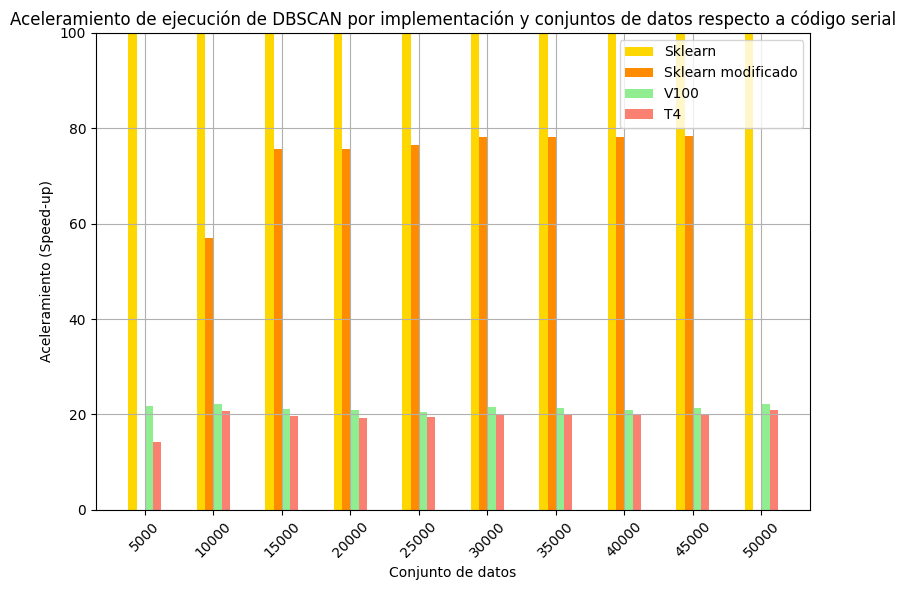

In [ ]:
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*1.5, speed_up_values_sklearn, width, label='Sklearn', color='gold')
rects1 = ax.bar(x - width/2, speed_up_values_sklearn_modified, width, label='Sklearn modificado', color='darkorange')
rects3 = ax.bar(x + width/2, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*1.5, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código serial')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)
ax.set_ylim(0, 100)

fig.tight_layout()
plt.show()

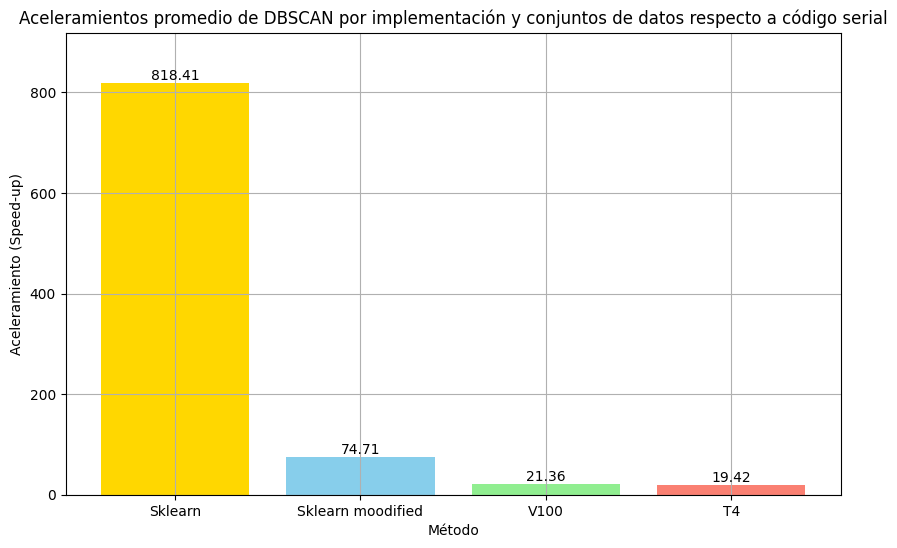

In [ ]:
# Calcular la media de los speed ups para A100, V100, y T4
mean_speedups_sklearn = sum(speed_ups_sklearn.values()) / len(speed_ups_sklearn)
mean_speedups_sklearn_modified = sum(speed_ups_sklearn_modified.values()) / len(speed_ups_sklearn_modified)
mean_speedups_V100 = sum(speed_ups_V100.values()) / len(speed_ups_V100)
mean_speedups_T4 = sum(speed_ups_T4.values()) / len(speed_ups_T4)

# Nombres de las GPUs y Sklearn
gpus = ['Sklearn', 'Sklearn moodified','V100', 'T4']

# Medias de los speed ups para cada GPU incluyendo Sklearn
mean_speedups = [mean_speedups_sklearn, mean_speedups_sklearn_modified, mean_speedups_V100, mean_speedups_T4]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(gpus, mean_speedups, color=['gold', 'skyblue', 'lightgreen', 'salmon'])
plt.grid(True)

plt.xlabel('Método')
plt.ylabel('Aceleramiento (Speed-up)')
plt.title('Aceleramientos promedio de DBSCAN por implementación y conjuntos de datos respecto a código serial')

# Agregar los valores de mean speed up sobre cada barra
for i, value in enumerate(mean_speedups):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom')

plt.ylim(0, max(mean_speedups) + 100)  # Ajustar el límite superior para mejor visualización

plt.show()


##### Aceleramiento respecto a Sklearn

In [ ]:
# Calculando el speed up
speed_ups_sklearn_modified = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_sklearn_modified[dataset]['mean_time'] for dataset in mean_results_sklearn_modified}
speed_ups_serial = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_serial[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_V100 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_V100[dataset]['mean_time'] for dataset in mean_results_sklearn}
speed_ups_T4 = {dataset: mean_results_sklearn[dataset]['mean_time'] / mean_results_T4[dataset]['mean_time'] for dataset in mean_results_sklearn}

# Preparación para la gráfica
datasets = list(mean_results_sklearn_modified.keys())
speed_up_values_sklearn_modified = [speed_ups_sklearn_modified[dataset] for dataset in datasets]

datasets = list(mean_results_serial.keys())
speed_up_values_serial = [speed_ups_serial[dataset] for dataset in datasets]
speed_up_values_V100 = [speed_ups_V100[dataset] for dataset in datasets]
speed_up_values_T4 = [speed_ups_T4[dataset] for dataset in datasets]


x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas

missing_values = len(x) - len(speed_up_values_sklearn_modified) - 1
speed_up_values_sklearn_modified = np.pad(speed_up_values_sklearn_modified, (1, missing_values), 'constant')

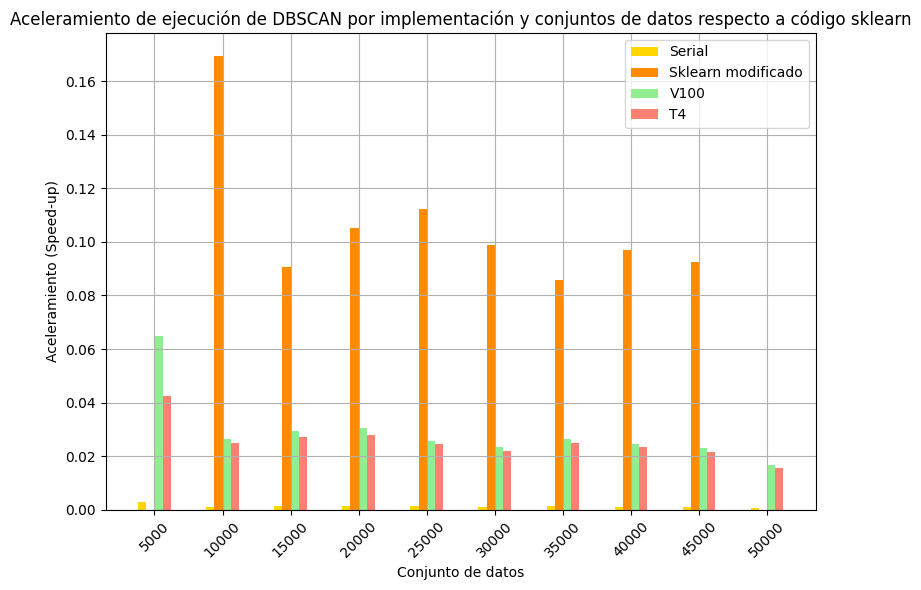

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*1.5, speed_up_values_serial, width, label='Serial', color='gold')
rects1 = ax.bar(x - width/2, speed_up_values_sklearn_modified, width, label='Sklearn modificado', color='darkorange')
rects3 = ax.bar(x + width/2, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*1.5, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código sklearn')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)

fig.tight_layout()
plt.show()

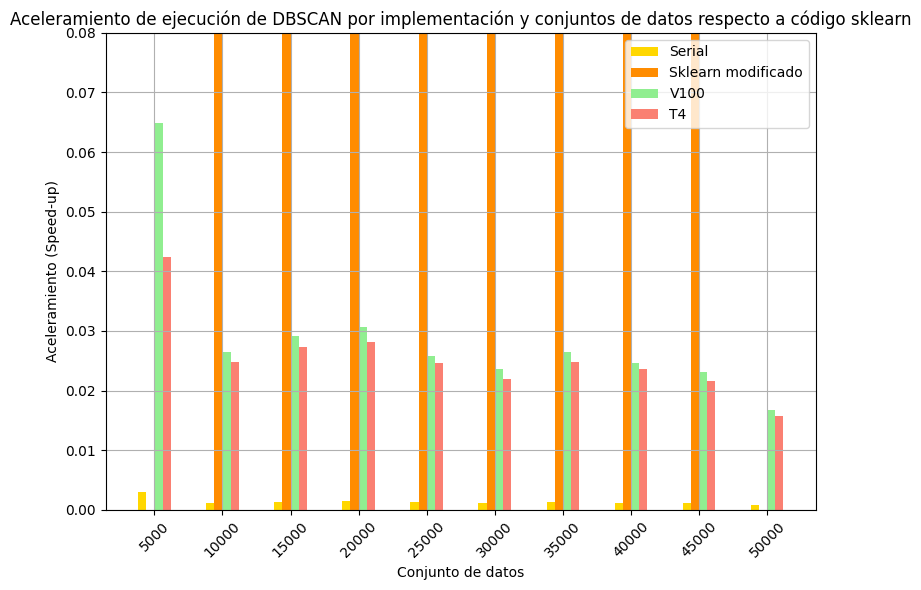

In [ ]:
x = np.arange(len(datasets))  # Las ubicaciones de las etiquetas
width = 0.12  # Ajustado para acomodar 5 series

fig, ax = plt.subplots(figsize=(8, 6))
rects0 = ax.bar(x - width*1.5, speed_up_values_serial, width, label='Serial', color='gold')
rects1 = ax.bar(x - width/2, speed_up_values_sklearn_modified, width, label='Sklearn modificado', color='darkorange')
rects3 = ax.bar(x + width/2, speed_up_values_V100, width, label='V100', color='lightgreen')
rects4 = ax.bar(x + width*1.5, speed_up_values_T4, width, label='T4', color='salmon')

# Añadir texto para etiquetas, título y etiquetas personalizadas en el eje X, etc.
ax.set_xlabel('Conjunto de datos')
ax.set_ylabel('Aceleramiento (Speed-up)')
ax.set_title('Aceleramiento de ejecución de DBSCAN por implementación y conjuntos de datos respecto a código sklearn')
ax.set_xticks(x)
ax.set_xticklabels(datasets, rotation=45)  # Rotar los nombres de los conjuntos de datos para mejor visibilidad
ax.legend()
ax.grid(True)
ax.set_ylim(0, 0.08)
fig.tight_layout()
plt.show()

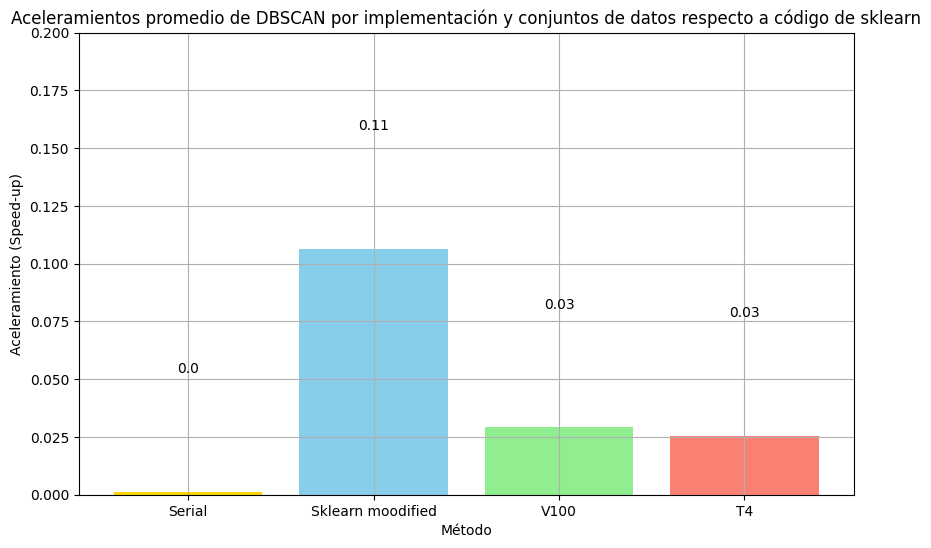

In [ ]:
# Calcular la media de los speed ups para A100, V100, y T4
mean_speedups_serial = sum(speed_ups_serial.values()) / len(speed_ups_serial)
mean_speedups_sklearn_modified = sum(speed_ups_sklearn_modified.values()) / len(speed_ups_sklearn_modified)
mean_speedups_V100 = sum(speed_ups_V100.values()) / len(speed_ups_V100)
mean_speedups_T4 = sum(speed_ups_T4.values()) / len(speed_ups_T4)

# Nombres de las GPUs y Sklearn
gpus = ['Serial', 'Sklearn moodified', 'V100', 'T4']

# Medias de los speed ups para cada GPU incluyendo Sklearn
mean_speedups = [mean_speedups_serial, mean_speedups_sklearn_modified, mean_speedups_V100, mean_speedups_T4]

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(gpus, mean_speedups, color=['gold', 'skyblue', 'lightgreen', 'salmon'])
plt.grid(True)

plt.xlabel('Método')
plt.ylabel('Aceleramiento (Speed-up)')
plt.title('Aceleramientos promedio de DBSCAN por implementación y conjuntos de datos respecto a código de sklearn')

# Agregar los valores de mean speed up sobre cada barra
for i, value in enumerate(mean_speedups):
    plt.text(i, value + 0.05, round(value, 2), ha='center', va='bottom')

plt.ylim(0,0.2)  # Ajustar el límite superior para mejor visualización

plt.show()


#### Uso de memoria

##### Promedios uso de memoria

###### Memoria Sklearn

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN
mean_results_sklearn = {}
for dataset_name, _ in sklearn_results.items():
    number_of_experiments = len(sklearn_results[dataset_name]['experiment'])
    sum_memory = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_memory += experiment[idx]['memory_usage']
    mean_memory = sum_memory / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_memory) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn[dataset_name] = {}
    mean_results_sklearn[dataset_name]['mean_cpu_memory'] = mean_memory
    mean_results_sklearn[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

display(mean_results_sklearn)

{'5000': {'mean_cpu_memory': 16.553333333333335,
  'std_dev_cpu_memory': 0.25263060428661877},
 '10000': {'mean_cpu_memory': 16.679999999999993,
  'std_dev_cpu_memory': 0.04760952285695174},
 '15000': {'mean_cpu_memory': 16.699999999999992,
  'std_dev_cpu_memory': 0.025819888974716022},
 '20000': {'mean_cpu_memory': 16.66666666666667,
  'std_dev_cpu_memory': 0.053748384988656146},
 '25000': {'mean_cpu_memory': 16.62,
  'std_dev_cpu_memory': 0.04760952285695162},
 '30000': {'mean_cpu_memory': 16.630000000000006,
  'std_dev_cpu_memory': 0.07810249675906625},
 '35000': {'mean_cpu_memory': 16.606666666666666,
  'std_dev_cpu_memory': 0.08537498983243802},
 '40000': {'mean_cpu_memory': 17.216666666666665,
  'std_dev_cpu_memory': 0.058214163988577004},
 '45000': {'mean_cpu_memory': 18.293333333333333,
  'std_dev_cpu_memory': 0.1181336343111292},
 '50000': {'mean_cpu_memory': 18.483333333333338,
  'std_dev_cpu_memory': 0.10979779394667089}}

###### Memoria Sklearn modificado GPU T4

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified_T4 = {}
for dataset_name, _ in sklearn_modified_results_T4.items():
    number_of_experiments = len(sklearn_modified_results_T4[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_T4[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_T4[dataset_name] = {}
    mean_results_sklearn_modified_T4[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_sklearn_modified_T4[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

mean_results_sklearn_modified_T4['25000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_T4['30000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_T4['35000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_T4['40000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_T4['45000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_T4['50000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}

for dataset_name, _ in sklearn_modified_results_T4.items():
    number_of_experiments = len(sklearn_modified_results_T4[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_T4[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_T4[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_sklearn_modified_T4[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_sklearn_modified_T4)

{'5000': {'mean_cpu_memory': 14.1,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 4.25,
  'std_dev_gpu_memory': 0.6500000000000001},
 '10000': {'mean_cpu_memory': 18.75,
  'std_dev_cpu_memory': 0.05000000000000071,
  'mean_gpu_memory': 12.3,
  'std_dev_gpu_memory': 2.5},
 '15000': {'mean_cpu_memory': 26.6,
  'std_dev_cpu_memory': 0.09999999999999964,
  'mean_gpu_memory': 19.8,
  'std_dev_gpu_memory': 6.2},
 '20000': {'mean_cpu_memory': 36.650000000000006,
  'std_dev_cpu_memory': 0.05000000000000071,
  'mean_gpu_memory': 27.799999999999997,
  'std_dev_gpu_memory': 5.6},
 '25000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '30000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '35000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '40000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.

###### Memoria Sklearn Modificado GPU V100

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SKLEARN MODIFICADO GPU
mean_results_sklearn_modified_V100 = {}
for dataset_name, _ in sklearn_modified_results_V100.items():
    number_of_experiments = len(sklearn_modified_results_V100[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_V100[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_V100[dataset_name] = {}
    mean_results_sklearn_modified_V100[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_sklearn_modified_V100[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

mean_results_sklearn_modified_V100['25000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_V100['30000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_V100['35000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_V100['40000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_V100['45000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}
mean_results_sklearn_modified_V100['50000']={'mean_cpu_memory': 100, 'std_dev_cpu_memory': 0.0, 'mean_gpu_memory': 100, 'std_dev_gpu_memory':0.0}


for dataset_name, _ in sklearn_modified_results_V100.items():
    number_of_experiments = len(sklearn_modified_results_V100[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = sklearn_modified_results_V100[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_sklearn_modified_V100[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_sklearn_modified_V100[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_sklearn_modified_V100)

{'5000': {'mean_cpu_memory': 13.7,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 4.55,
  'std_dev_gpu_memory': 0.04999999999999982},
 '10000': {'mean_cpu_memory': 18.85,
  'std_dev_cpu_memory': 0.25,
  'mean_gpu_memory': 11.5,
  'std_dev_gpu_memory': 2.3000000000000007},
 '15000': {'mean_cpu_memory': 27.200000000000003,
  'std_dev_cpu_memory': 0.09999999999999964,
  'mean_gpu_memory': 19.05,
  'std_dev_gpu_memory': 5.25},
 '20000': {'mean_cpu_memory': 37.849999999999994,
  'std_dev_cpu_memory': 0.05000000000000071,
  'mean_gpu_memory': 27.2,
  'std_dev_gpu_memory': 5.199999999999999},
 '25000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '30000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '35000': {'mean_cpu_memory': 100,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 100,
  'std_dev_gpu_memory': 0.0},
 '40000': {'mean_cpu_memory': 100,
  'std_de

###### Memoria Serial

In [ ]:
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo SERIAL
mean_results_serial = {}
for dataset_name, _ in serial_results.items():
    number_of_experiments = len(serial_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = serial_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['memory_usage']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['memory_usage'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_serial[dataset_name] = {}
    mean_results_serial[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_serial[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

display(mean_results_serial)

{'5000': {'mean_cpu_memory': 39.5, 'std_dev_cpu_memory': 0.0},
 '10000': {'mean_cpu_memory': 39.55,
  'std_dev_cpu_memory': 0.05000000000000071},
 '15000': {'mean_cpu_memory': 39.55,
  'std_dev_cpu_memory': 0.05000000000000071},
 '20000': {'mean_cpu_memory': 39.3, 'std_dev_cpu_memory': 0.09999999999999788},
 '25000': {'mean_cpu_memory': 40.0, 'std_dev_cpu_memory': 0.10000000000000142},
 '30000': {'mean_cpu_memory': 45.349999999999994,
  'std_dev_cpu_memory': 0.05000000000000071},
 '35000': {'mean_cpu_memory': 53.25,
  'std_dev_cpu_memory': 0.14999999999999858},
 '40000': {'mean_cpu_memory': 64.8, 'std_dev_cpu_memory': 0.29999999999999716},
 '45000': {'mean_cpu_memory': 71.9, 'std_dev_cpu_memory': 0.3999999999999986},
 '50000': {'mean_cpu_memory': 67.05, 'std_dev_cpu_memory': 2.950000000000003}}

###### Memoria GPU V100

In [ ]:
mean_results_V100 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['cpu_memory']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['cpu_memory'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_V100[dataset_name] = {}
    mean_results_V100[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_V100[dataset_name]['std_dev_cpu_memory'] = std_dev_mem


for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_V100[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_V100[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_V100)

{'5000': {'mean_cpu_memory': 17.7,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 18.1,
  'std_dev_gpu_memory': 0.09999999999999964},
 '10000': {'mean_cpu_memory': 17.7,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 11.65,
  'std_dev_gpu_memory': 7.15},
 '15000': {'mean_cpu_memory': 17.6,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 6.449999999999999,
  'std_dev_gpu_memory': 0.6499999999999999},
 '20000': {'mean_cpu_memory': 17.65,
  'std_dev_cpu_memory': 0.04999999999999894,
  'mean_gpu_memory': 6.85,
  'std_dev_gpu_memory': 1.15},
 '25000': {'mean_cpu_memory': 17.75,
  'std_dev_cpu_memory': 0.05000000000000071,
  'mean_gpu_memory': 13.45,
  'std_dev_gpu_memory': 1.8500000000000005},
 '30000': {'mean_cpu_memory': 18.5,
  'std_dev_cpu_memory': 0.6000000000000014,
  'mean_gpu_memory': 11.2,
  'std_dev_gpu_memory': 2.6000000000000005},
 '35000': {'mean_cpu_memory': 18.15,
  'std_dev_cpu_memory': 0.04999999999999894,
  'mean_gpu_memory': 24.55,
  'std_dev_gpu_memory': 3.550000

In [ ]:
print(V100_results["5000"])

{'experiment': {'0': {'execution_time': 1.6834957599639893, 'cpu_memory': 17.7, 'gpu_memory': 18.0, 'clusters': 2, 'core_points': 4881}, '1': {'execution_time': 1.675004482269287, 'cpu_memory': 17.7, 'gpu_memory': 18.2, 'clusters': 2, 'core_points': 4881}}}


In [ ]:
for dataset_name, _ in V100_results.items():
    number_of_experiments = len(V100_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = V100_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_V100[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_V100[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_V100)

{'5000': {'mean_cpu_memory': 17.7,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 18.1,
  'std_dev_gpu_memory': 0.09999999999999964},
 '10000': {'mean_cpu_memory': 17.7,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 11.65,
  'std_dev_gpu_memory': 7.15},
 '15000': {'mean_cpu_memory': 17.6,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 6.449999999999999,
  'std_dev_gpu_memory': 0.6499999999999999},
 '20000': {'mean_cpu_memory': 17.65,
  'std_dev_cpu_memory': 0.04999999999999894,
  'mean_gpu_memory': 6.85,
  'std_dev_gpu_memory': 1.15},
 '25000': {'mean_cpu_memory': 17.75,
  'std_dev_cpu_memory': 0.05000000000000071,
  'mean_gpu_memory': 13.45,
  'std_dev_gpu_memory': 1.8500000000000005},
 '30000': {'mean_cpu_memory': 18.5,
  'std_dev_cpu_memory': 0.6000000000000014,
  'mean_gpu_memory': 11.2,
  'std_dev_gpu_memory': 2.6000000000000005},
 '35000': {'mean_cpu_memory': 18.15,
  'std_dev_cpu_memory': 0.04999999999999894,
  'mean_gpu_memory': 24.55,
  'std_dev_gpu_memory': 3.550000

###### Memoria GPU T4

In [ ]:
mean_results_T4 = {}
# Obtención de tiempos promedios y desviaciones estándar con el algoritmo PARALELO
for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['cpu_memory']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['cpu_memory'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_T4[dataset_name] = {}
    mean_results_T4[dataset_name]['mean_cpu_memory'] = mean_mem
    mean_results_T4[dataset_name]['std_dev_cpu_memory'] = std_dev_mem

for dataset_name, _ in T4_results.items():
    number_of_experiments = len(T4_results[dataset_name]['experiment'])
    sum_mem = 0.0
    std_dev_mem = 0.0
    experiment = T4_results[dataset_name]['experiment']
    for idx, _ in experiment.items():
        sum_mem += experiment[idx]['gpu_memory']
    mean_mem = sum_mem / number_of_experiments
    for idx, _ in experiment.items():
        std_dev_mem += (experiment[idx]['gpu_memory'] - mean_mem) ** 2
    std_dev_mem = np.sqrt(std_dev_mem / number_of_experiments)

    mean_results_T4[dataset_name]['mean_gpu_memory'] = mean_mem
    mean_results_T4[dataset_name]['std_dev_gpu_memory'] = std_dev_mem

display(mean_results_T4)

{'5000': {'mean_cpu_memory': 12.8,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 2.6,
  'std_dev_gpu_memory': 0.10000000000000009},
 '10000': {'mean_cpu_memory': 14.2,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 3.5999999999999996,
  'std_dev_gpu_memory': 0.30000000000000004},
 '15000': {'mean_cpu_memory': 19.2,
  'std_dev_cpu_memory': 1.6999999999999993,
  'mean_gpu_memory': 4.5,
  'std_dev_gpu_memory': 0.7000000000000002},
 '20000': {'mean_cpu_memory': 24.05,
  'std_dev_cpu_memory': 1.5500000000000007,
  'mean_gpu_memory': 8.95,
  'std_dev_gpu_memory': 1.2499999999999996},
 '25000': {'mean_cpu_memory': 35.4,
  'std_dev_cpu_memory': 0.0,
  'mean_gpu_memory': 10.7,
  'std_dev_gpu_memory': 1.8999999999999995},
 '30000': {'mean_cpu_memory': 41.099999999999994,
  'std_dev_cpu_memory': 0.1999999999999993,
  'mean_gpu_memory': 13.1,
  'std_dev_gpu_memory': 5.1},
 '35000': {'mean_cpu_memory': 49.85,
  'std_dev_cpu_memory': 0.14999999999999858,
  'mean_gpu_memory': 19.4,
  'std_dev_

##### Gráficas uso de memoria

###### Memoria RAM

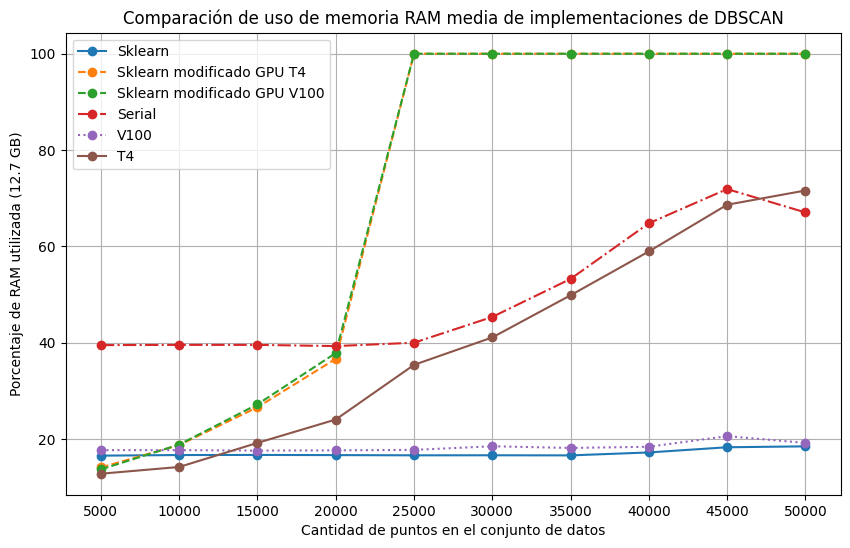

In [ ]:
def extract_data(dic):
    x_values = [int(key) for key in dic.keys()]
    y_values = [val['mean_cpu_memory'] for val in dic.values()]
    # Ordenar x e y según x para asegurar que el gráfico se vea correcto
    sorted_indices = np.argsort(x_values)
    return np.array(x_values)[sorted_indices], np.array(y_values)[sorted_indices]

# Extraer datos para cada diccionario
x, y_sklearn = extract_data(mean_results_sklearn)
_, y_sklearn_mod_T4 = extract_data(mean_results_sklearn_modified_T4)
_, y_sklearn_mod_V100 = extract_data(mean_results_sklearn_modified_V100)
_, y_serial = extract_data(mean_results_serial)
_, y_V100 = extract_data(mean_results_V100)
_, y_T4 = extract_data(mean_results_T4)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_sklearn, label='Sklearn', marker='o', linestyle='-')
plt.plot(x, y_sklearn_mod_T4, label='Sklearn modificado GPU T4', marker='o', linestyle='--')
plt.plot(x, y_sklearn_mod_V100, label='Sklearn modificado GPU V100', marker='o', linestyle='--')
plt.plot(x, y_serial, label='Serial', marker='o', linestyle='-.')
plt.plot(x, y_V100, label='V100', marker='o', linestyle=':')
plt.plot(x, y_T4, label='T4', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de RAM utilizada (12.7 GB)')
plt.title('Comparación de uso de memoria RAM media de implementaciones de DBSCAN')
plt.xticks(x)  # Asegurar que todos los valores de x aparezcan como etiquetas
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()

###### Memoria VRAM

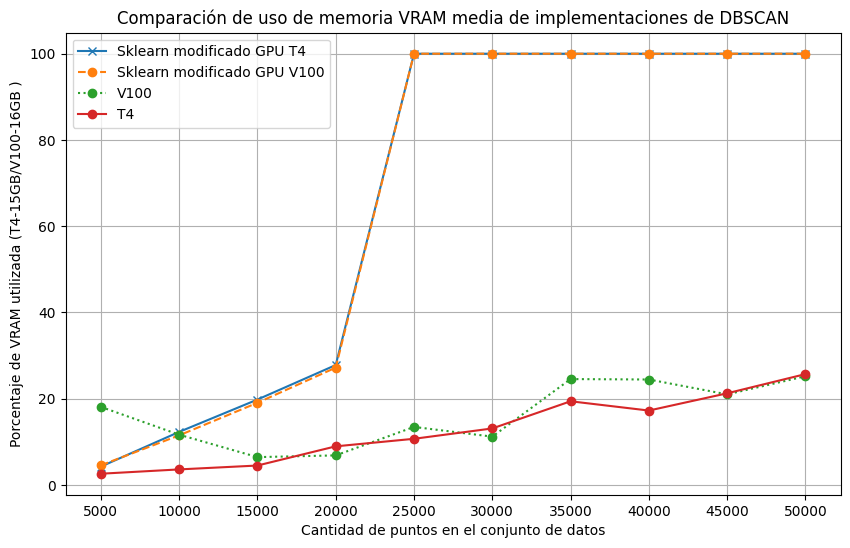

In [ ]:
def extract_data(dic):
    x_values = [int(key) for key in dic.keys()]
    y_values = [val['mean_gpu_memory'] for val in dic.values()]
    # Ordenar x e y según x para asegurar que el gráfico se vea correcto
    sorted_indices = np.argsort(x_values)
    return np.array(x_values)[sorted_indices], np.array(y_values)[sorted_indices]

# Extraer datos para cada diccionario
x, y_sklearn_mod_T4 = extract_data(mean_results_sklearn_modified_T4)
_, y_sklearn_mod_V100 = extract_data(mean_results_sklearn_modified_V100)
_, y_V100 = extract_data(mean_results_V100)
_, y_T4 = extract_data(mean_results_T4)

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(x, y_sklearn_mod_T4, label='Sklearn modificado GPU T4', marker='x', linestyle='-')
plt.plot(x, y_sklearn_mod_V100, label='Sklearn modificado GPU V100', marker='o', linestyle='--')
plt.plot(x, y_V100, label='V100', marker='o', linestyle=':')
plt.plot(x, y_T4, label='T4', marker='o', linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Cantidad de puntos en el conjunto de datos')
plt.ylabel('Porcentaje de VRAM utilizada (T4-15GB/V100-16GB )')
plt.title('Comparación de uso de memoria VRAM media de implementaciones de DBSCAN')
plt.xticks(x)  # Asegurar que todos los valores de x aparezcan como etiquetas
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()
